In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- If youve already done this for Ne, you dont need to do here too

In [2]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.11.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [3]:
import DiadFit as pf
pf.__version__

'0.0.21'

In [4]:
# Add the path with your spectra in
mypath=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\High_Density_Looping_Run\Spectra'

In [5]:
# This specifies what file type your Raman exported in. 
filetype='headless_txt'
# Specifying the extension here helps to filter out other file types,
# e.g. png files that may be in the folder
file_ext='.txt'
# If your instrument appends a nubmer like 01, 02 to each file, prefix=True removes it
prefix=False

## This function finds all files in your path with the specified file format
- As you will fit your Ne lines in a different workbook, you can use 'exclude_str' to put any text that appears in all your Ne files, and it won't look here

In [6]:
Diad_files=pf.get_diad_files(path=mypath, file_ext=file_ext, exclude_str='Ne',
                            exclude_str_2='ne')
Diad_files

exclude type
.png


['FI_1225down_1.txt',
 'FI_1225down_2.txt',
 'FI_1225up_1.txt',
 'FI_1225up_2.txt',
 'FI_1250down_1.txt',
 'FI_1250down_2.txt',
 'FI_1250up_1.txt',
 'FI_1250up_2.txt',
 'FI_1275down_1.txt',
 'FI_1275down_2.txt',
 'FI_1275up_1.txt',
 'FI_1275up_2.txt',
 'FI_1300down_1.txt',
 'FI_1300down_2.txt',
 'FI_1300up_1.txt',
 'FI_1300up_2.txt',
 'FI_1325down_1.txt',
 'FI_1325down_2.txt',
 'FI_1325up_1.txt',
 'FI_1325up_2.txt',
 'FI_1350up_1.txt',
 'FI_1350up_2.txt']

## Select the first file you want to fit
- This allows you to tweak parameters for your spectra and your instrument

In [7]:
filename=Diad_files[0] # This finds the first file

# Alternatively, you can specify the actual file name if you want to fit a specific one
#filename='007_k9.csv'
print(filename)

FI_1225down_1.txt


## First we plot the spectra
- This lets you look at the spectra, decide how strong your hotbands are, and see how elevated the diads are (if they are very elevated, you may need to fit a gaussian background too)

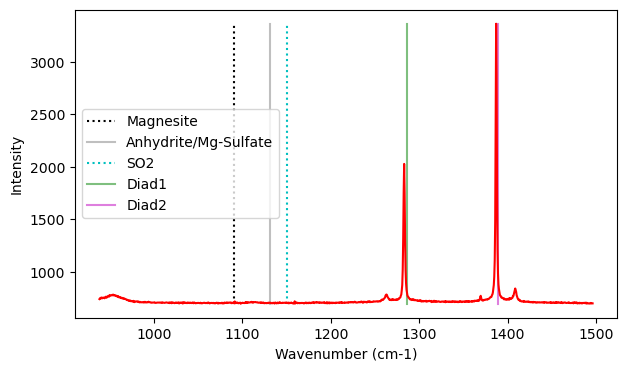

In [8]:
pf.plot_diad(path=mypath, filename=filename, filetype=filetype)

## After inspecting the spectra, decide if you want to fit the carbonate peak
- First, look at the presets, you can edit them in carb_peak_config by typing the variable name, and a new value

In [9]:
# Decide if you want to fit a carbonate peak or not here. 
fit_carbonate=False

# Tweak options here, can exclude a range for example using exclude_range=Tuple[float, float]
Carb_Config=pf.carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330))
Carb_Config   

carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330), N_poly_carb_bck=1, amplitude=1000, cent_carbonate=1090, outlier_sigma=12, N_peaks=3, distance=10, prominence=5, width=6, threshold=0.1, exclude_range=None, dpi=100, plot_figure=True)

## This actually does the work fitting the carbonate peak

In [10]:
Carb_fit=pf.fit_carbonate_peak(config=Carb_Config, path=mypath, 
filename=filename, filetype=filetype,
fit_carbonate=fit_carbonate)
Carb_fit

## Now lets plot the diads
- As with carbonate, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

In [11]:
diad_id_config=pf.diad_id_config()
diad_id_config

diad_id_config(exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1395), approx_diad1_pos=(1275, 1295), height=400, distance=5, threshold=0.5, width=0.5, prominence=10, plot_figure=True)

Initial estimates: Diad1+HB=[1283. 1263.], Diad2+HB=[1387.  1408.6]


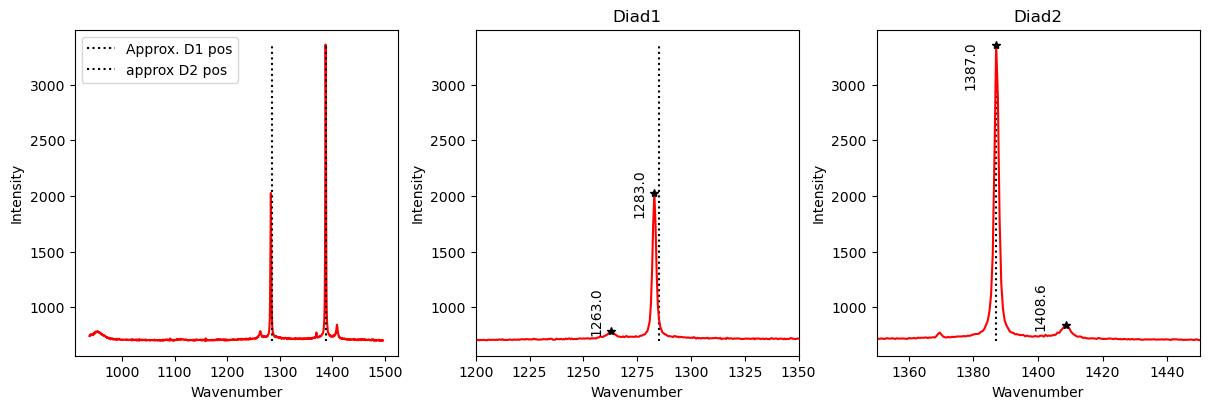

In [12]:
# Specify the number of peaks, 1 = just peak, 2 = Peak+hot bands
n_peaks_diad1=2
n_peaks_diad2=2 

    
diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config,
                        path=mypath, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, n_peaks_diad2=n_peaks_diad2,
                                               block_print=False)

## Lets make the same plot, but for all our diads... to see what they all look like...

## If you have no diads visible...
- change True to False, and it will just save the carbonate peak parameters

In [14]:
diads_present=True
pf.proceed_to_fit_diads(filename, Carb_fit, diads_present=diads_present)

Move on to fit diads


## Fit Diad 1
- This function uses the guess of the peak parameters above. 
- For very dense diads, you may need to fit a gaussian background, defined by peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000
- Otherwise, the background is fitted with a polynomial you can set the degree for (Default =1) based on background positoins defined by lower_bck, upper_bck...
- If plot_figure=True, it saves the figure in its own folder in the path, so you can inspect all the fits at a later date. 

In [30]:
diad1_fit_config=pf.diad1_fit_config(peak_pos_gauss=(1280), 
                                     gauss_sigma=2,
                                     gauss_amp=200,
                                    lower_bck_diad1=(1180, 1220),
                                     upper_bck_diad1=(1320, 1350),
                                     x_range_residual=10, x_range_baseline=50,
                                    HB_amplitude=100, diad_amplitude=1000)
diad1_fit_config

diad1_fit_config(peak_pos_gauss=1280, gauss_sigma=2, gauss_amp=200, N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1320, 1350), diad_amplitude=1000, HB_amplitude=100, x_range_baseline=50, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

Gauss_cent=1278.9133805266772
Gauss_amp=869.7468766159888
Gauss_sigma=19.999995212900878
Making summary figure of different fits for saving
[ -1.8008835   -5.05340766   1.93823592  -5.06641853  -6.32476981
  -6.31865888  -0.36791299  -4.85158656  -1.4475463   -3.40506899
  -6.69070833  -0.90546105  -7.2548832    3.09602269  -6.03232161
   4.9253588    6.30035858 -14.49940515  15.51245551 -10.25923975
  -2.97319792   2.75475873  11.96587028   9.52490295   7.55108296
  -1.32920522   3.93444488   0.70569226   4.16765301   0.27854707
  -4.31630037  -0.14115349  -1.81746564  -1.02560612  -4.28292259
   4.86926331   6.4733882 ]


Diad1_Cent   Diad1_Area    HB1_Cent    HB1_Area  Residual_Diad1
0  1282.980455  3411.579935  1262.78925  298.278755          2.7992

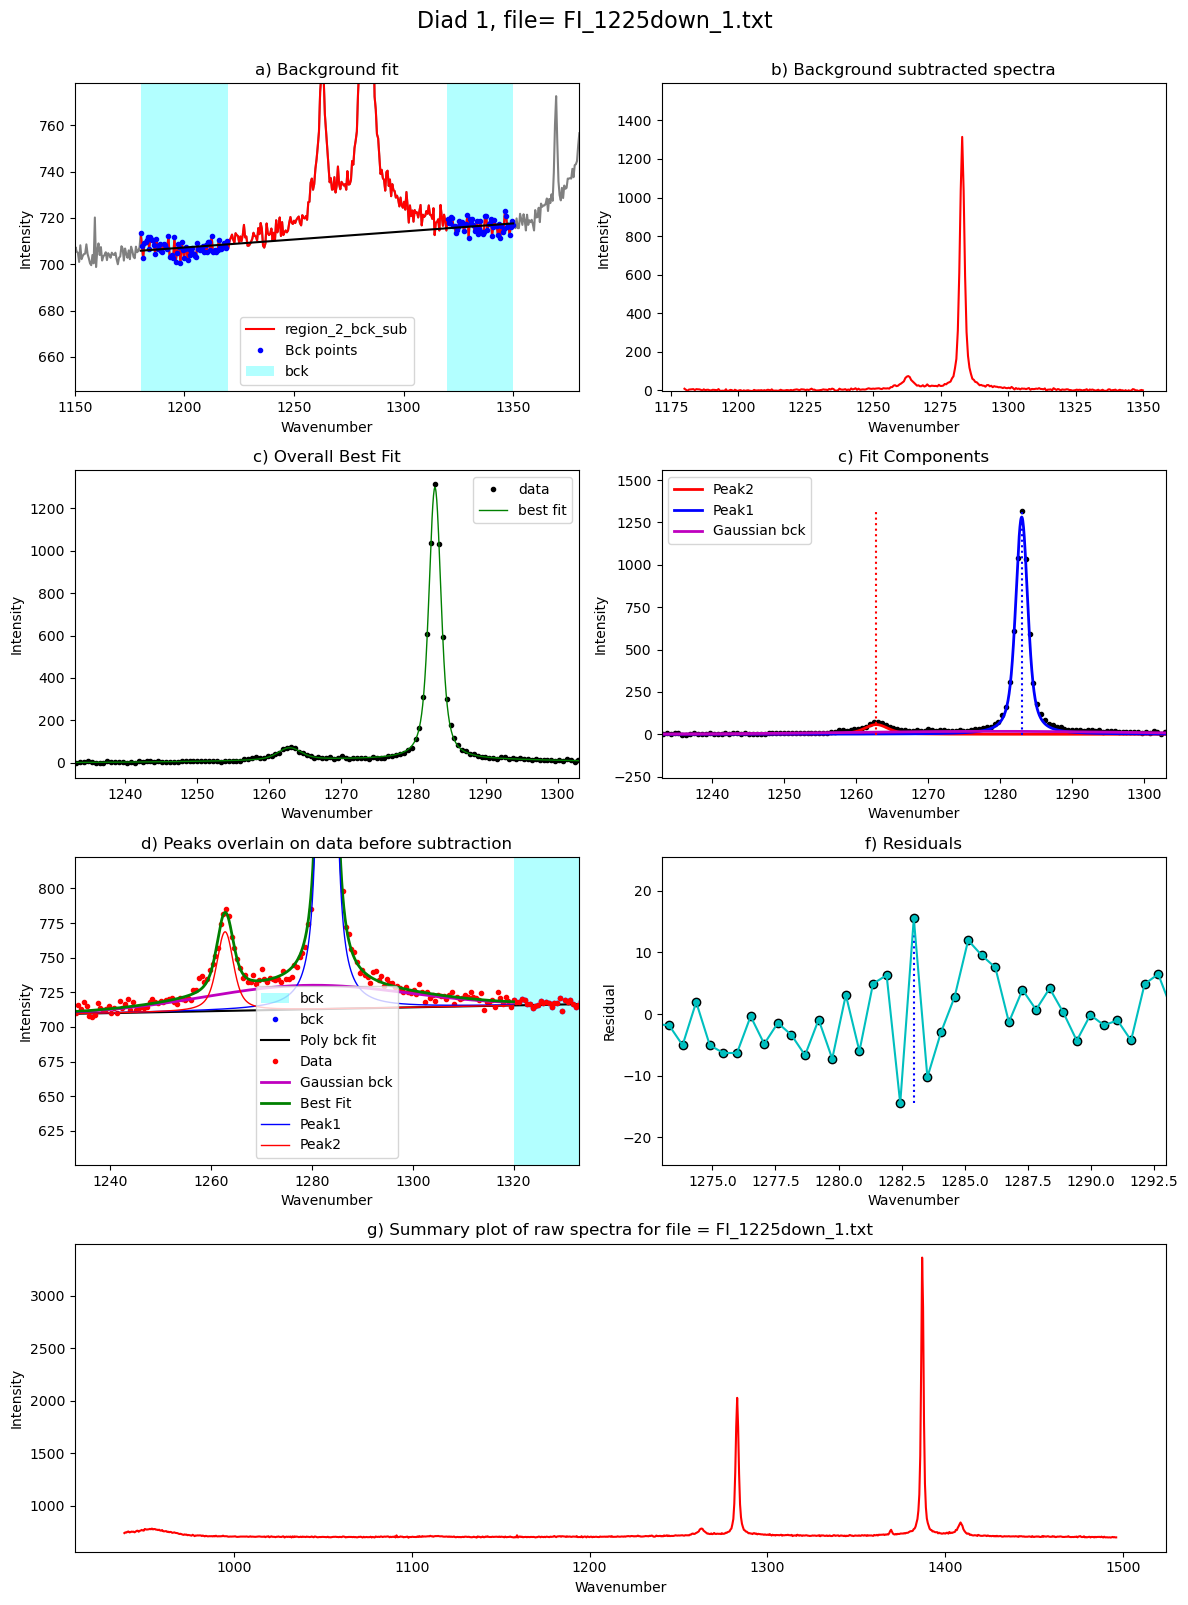

In [31]:
# For very dense spectra, with a very elevated background, you'll need to add a gaussian fit
# If you put a number in brackets, it'll center a gaussian extra background near there. 

# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype, block_print=False)
Diad1_fit

## Fit diad 2

In [38]:
diad2_fit_config=pf.diad2_fit_config(x_range_residual=10, x_range_baseline=50,
                                     lower_bck_diad2=(1320, 1340),
                                     peak_pos_gauss=(1390), 
                                     gauss_sigma=3,
                                     gauss_amp=200,
                                   diad_amplitude=10  )
diad2_fit_config

diad2_fit_config(peak_pos_gauss=1390, gauss_sigma=3, gauss_amp=200, N_poly_bck_diad2=1, lower_bck_diad2=(1320, 1340), upper_bck_diad2=(1440, 1470), diad_amplitude=10, HB_amplitude=20, x_range_baseline=50, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

Diad2_Cent   Diad2_Area     HB2_Cent    HB2_Area  Residual_Diad2
0  1387.138986  5630.578371  1408.589402  541.314631        4.963711

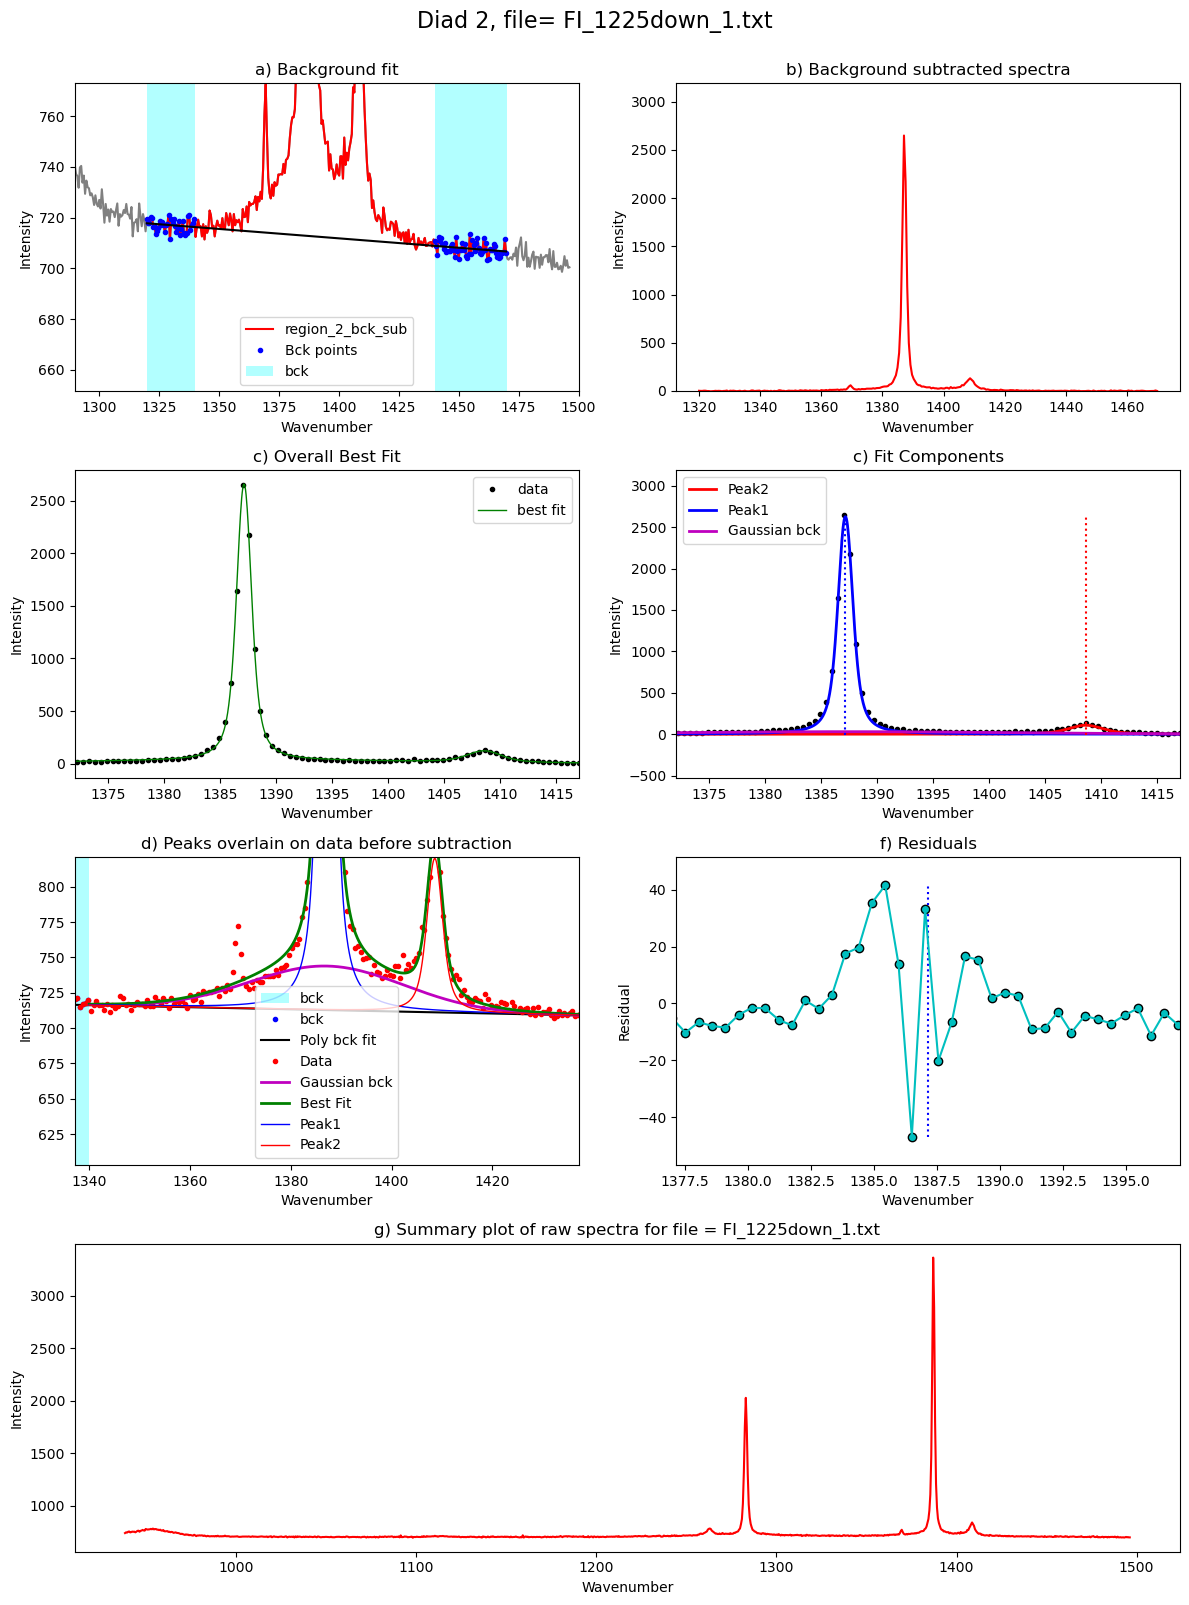

In [39]:
# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad2_peaks,
path=mypath, filename=filename, filetype=filetype)
Diad2_fit

## Combine and save
- Saves to clipboard if to_clipboard=True (e.g. you can paste into a spreadsheet)
- Also saves to 'csv' in a folder in "mypath" if to_csv=True)
- It also makes a new 

In [40]:
out=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, to_clipboard=True, to_csv=True, path=mypath,
Diad2_fit=Diad2_fit, Carb_fit=Carb_fit)
out

filename   Splitting   Diad1_Cent   Diad1_Area  Residual_Diad1  \
0  FI_1225down_1  104.158531  1282.980455  3411.579935          2.7992   

    Diad2_Cent   Diad2_Area  Residual_Diad2    HB1_Cent    HB1_Area  \
0  1387.138986  5630.578371        4.963711  1262.78925  298.278755   

      HB2_Cent    HB2_Area  C13_Cent  C13_Area  
0  1408.589402  541.314631       NaN         0

In [41]:
out

filename   Splitting   Diad1_Cent   Diad1_Area  Residual_Diad1  \
0  FI_1225down_1  104.158531  1282.980455  3411.579935          2.7992   

    Diad2_Cent   Diad2_Area  Residual_Diad2    HB1_Cent    HB1_Area  \
0  1387.138986  5630.578371        4.963711  1262.78925  298.278755   

      HB2_Cent    HB2_Area  C13_Cent  C13_Area  
0  1408.589402  541.314631       NaN         0

## You can also try looping if all your spectra are pretty similar

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

[ -1.8008835   -5.05340766   1.93823592  -5.06641853  -6.32476981
  -6.31865888  -0.36791299  -4.85158656  -1.4475463   -3.40506899
  -6.69070833  -0.90546105  -7.2548832    3.09602269  -6.03232161
   4.9253588    6.30035858 -14.49940515  15.51245551 -10.25923975
  -2.97319792   2.75475873  11.96587028   9.52490295   7.55108296
  -1.32920522   3.93444488   0.70569226   4.16765301   0.27854707
  -4.31630037  -0.14115349  -1.81746564  -1.02560612  -4.28292259
   4.86926331   6.4733882 ]


  5%|███▊                                                                               | 1/22 [00:01<00:41,  2.00s/it]

[-2.14944308 -4.9309992  -3.26067658 -1.17714029 -0.53543636 -1.81447844
 -3.52997586 -6.65577155 -4.86305538 -6.79288029  2.79608335  1.9027478
 -0.71790828  1.95694076  5.29361642 -4.12280201 -0.40038969 -3.55164731
  7.69123786 -7.09496615 -6.18233819  8.8059285  12.21126857  7.14161103
  3.98424222  4.58320662  0.2720186   2.96169931 -0.77563111  0.50901613
 -0.20041798  1.53526763  4.27175423  1.71377937  1.93397083 -1.6160361
  0.50113169]


  9%|███████▌                                                                           | 2/22 [00:03<00:38,  1.95s/it]

[ -3.50024619  -2.00410818  -7.67482496   1.04415164  -2.50858276
  -7.02092209   0.97905531  -4.30078714  -4.55809806  -9.47441744
  -4.47174412   1.14720381   3.17114838   4.56335271  -1.91293749
   9.85820281  -9.32018363  -6.07193945  17.03270051 -16.93585269
  -4.14526581  14.32790948  15.83984877   4.7750953    3.53665795
   2.1847918   -1.23177247   2.62897345   1.84033565   1.81043844
   0.81370863   1.14432944   1.79263015   0.08634729  -3.48639525
   2.7369638   -2.39829498]


 14%|███████████▎                                                                       | 3/22 [00:14<01:56,  6.12s/it]

[-2.32411026 -6.57645776 -0.78600675 -8.39265539  0.14677236 -6.24942161
 -6.30090352 -2.18751127 -5.98896649 -4.95961566 -2.07827729 -1.57764816
 -0.35123591 -5.03785828  7.69247446  4.72408003 -4.75375948 -2.92967016
  7.95718517 -8.01270103 -0.93227699  6.11142363  3.77054052  3.40737183
  2.54136904  7.17331613  2.19761087 -5.04149705 -2.0608009   5.84717974
  1.0996617  -0.84397122 -2.21533774  2.69876209 -1.42340858 -0.12614916
 -0.76920473]


 18%|███████████████                                                                    | 4/22 [00:17<01:21,  4.55s/it]

[-3.15570918e+00 -7.24271256e+00 -2.69975657e+00 -2.77155323e+00
 -2.52184252e+00 -2.04217986e+00  2.53279959e+00 -2.60010627e+00
 -5.35893332e+00 -4.06428354e+00 -1.78034419e-02 -4.89988516e+00
  3.31886758e-02  2.57353162e-01  5.72276438e+00  3.34947550e+00
 -7.88130185e+00 -3.04086965e+00  1.65370830e+01 -2.44775611e+01
  8.13815884e+00  1.16270516e+01  1.06486865e+01  4.19050790e+00
  8.57464505e+00  6.16089350e-01 -7.72842075e-02 -1.92613272e+00
 -8.91049393e+00  4.85048598e+00  7.16220409e+00  2.47854732e+00
 -3.43468142e+00  3.34647800e-01  4.86437930e+00 -6.98999616e+00
  1.41194868e+00]


 23%|██████████████████▊                                                                | 5/22 [00:19<01:02,  3.65s/it]

[  0.44184763  -1.64669222  -1.70062804   0.23502946  -5.30362143
  -9.60849897  -4.01477516   0.07275477   3.53228559  -3.96541188
  -3.14325115  -9.93640095  -0.5565553   -0.02985772   4.11582057
   6.10399678 -10.58002163   3.39927709   4.83459684  -8.36494764
  -7.13746645  11.66979133  22.05645657   6.81421573   3.04720028
   3.5385315    1.44835108  -0.10847035   2.3642594   -0.31665932
  -1.98161644   0.20197284   3.18672273   1.67602032  -1.25801132
   3.636146    -0.40393829]


 27%|██████████████████████▋                                                            | 6/22 [00:21<00:49,  3.11s/it]

[ -4.38060241  -0.71789961  -0.22102164   0.06501253   0.07681515
  -1.27674676  -6.72884207  -6.68009957  -4.04350296  -3.92926264
   0.18304021   4.86383375   3.58939644   4.63105422   3.38029576
   2.85393476 -14.96186707   6.39292037   7.48864282 -15.68240643
  -0.79021995  16.6021061   13.6780809    0.63863045   2.63290109
   0.11259026   6.51165338   8.77937543   0.813533    -0.26543335
  -1.83036821   0.98536834  -1.04460628   4.19671643  -3.60943268
   1.99469858   3.85096484]


 32%|██████████████████████████▍                                                        | 7/22 [00:23<00:42,  2.80s/it]

[-11.05576674 -15.73145748  -9.3416737   -5.93230538  -8.56661387
  -8.93441663  -5.76631463  -6.45839038 -11.71704988 -13.04368509
  -5.10770593  -6.33427842  -3.88060258  -0.49005727   5.71658173
  -1.24650695  -1.94707472  -0.96362276   7.96606772 -13.53970721
   3.51731347   7.98613882  10.88623274  11.48581452  -0.38233197
   2.24450207  -0.36507744   4.53684121   4.4573122   -1.18376173
  -0.41646594   1.59138048   1.99156881   3.4865224    4.74752068
   2.42526197   4.15639468]


 36%|██████████████████████████████▏                                                    | 8/22 [00:25<00:35,  2.56s/it]

[  3.73317486   0.44872246  -9.20182697  -3.26230354  -0.99503852
   1.51072731  -4.27581327  -5.75127654  -4.62240194  -4.78868601
  -6.50994272   1.02355396  -3.0240809   -1.75323781   2.28997393
   4.47266109  -0.73927423 -10.91111554  17.88543215 -15.94176967
  -4.51701254  10.57464245  15.14566627  12.95994836   7.99512372
   5.65760018   1.62391019  -0.54478297   4.45290889  -0.86185907
  -5.06189202  -4.28068145   1.65508432   1.26223196  -4.17827767
   0.19126954  -0.38734058]


 41%|█████████████████████████████████▉                                                 | 9/22 [00:29<00:41,  3.22s/it]


TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

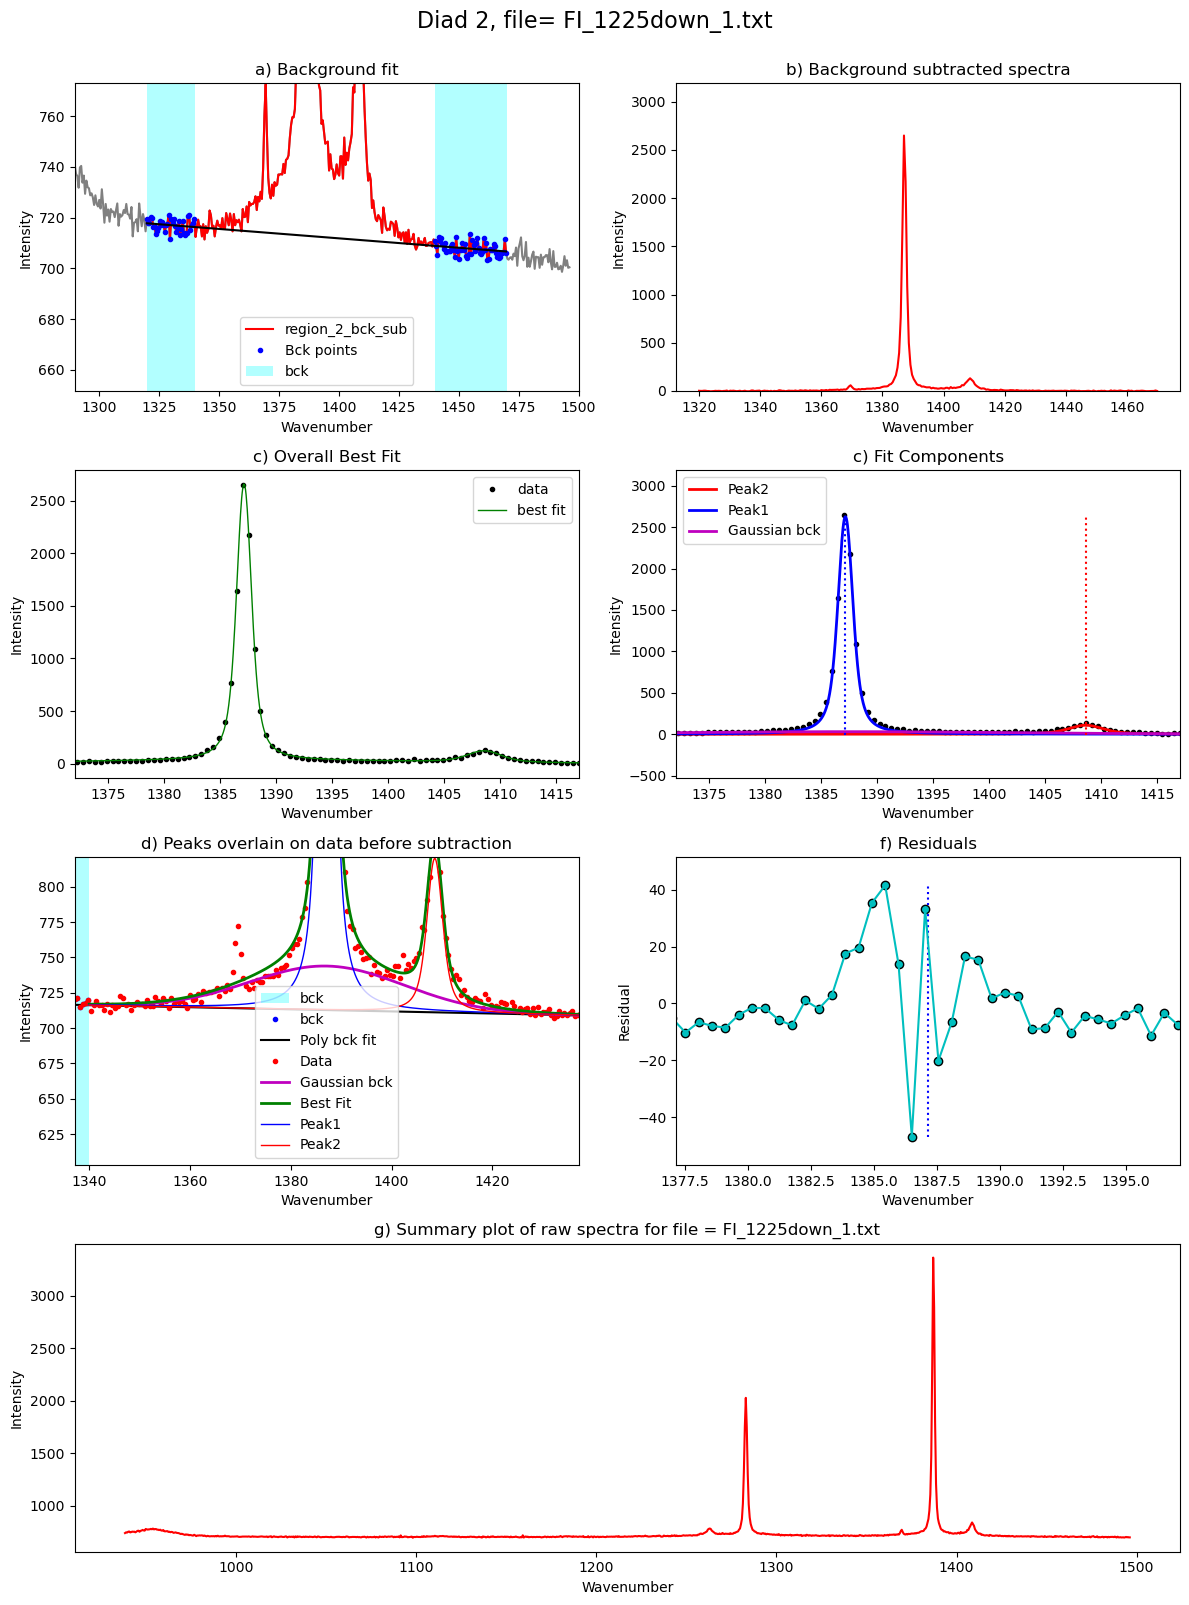

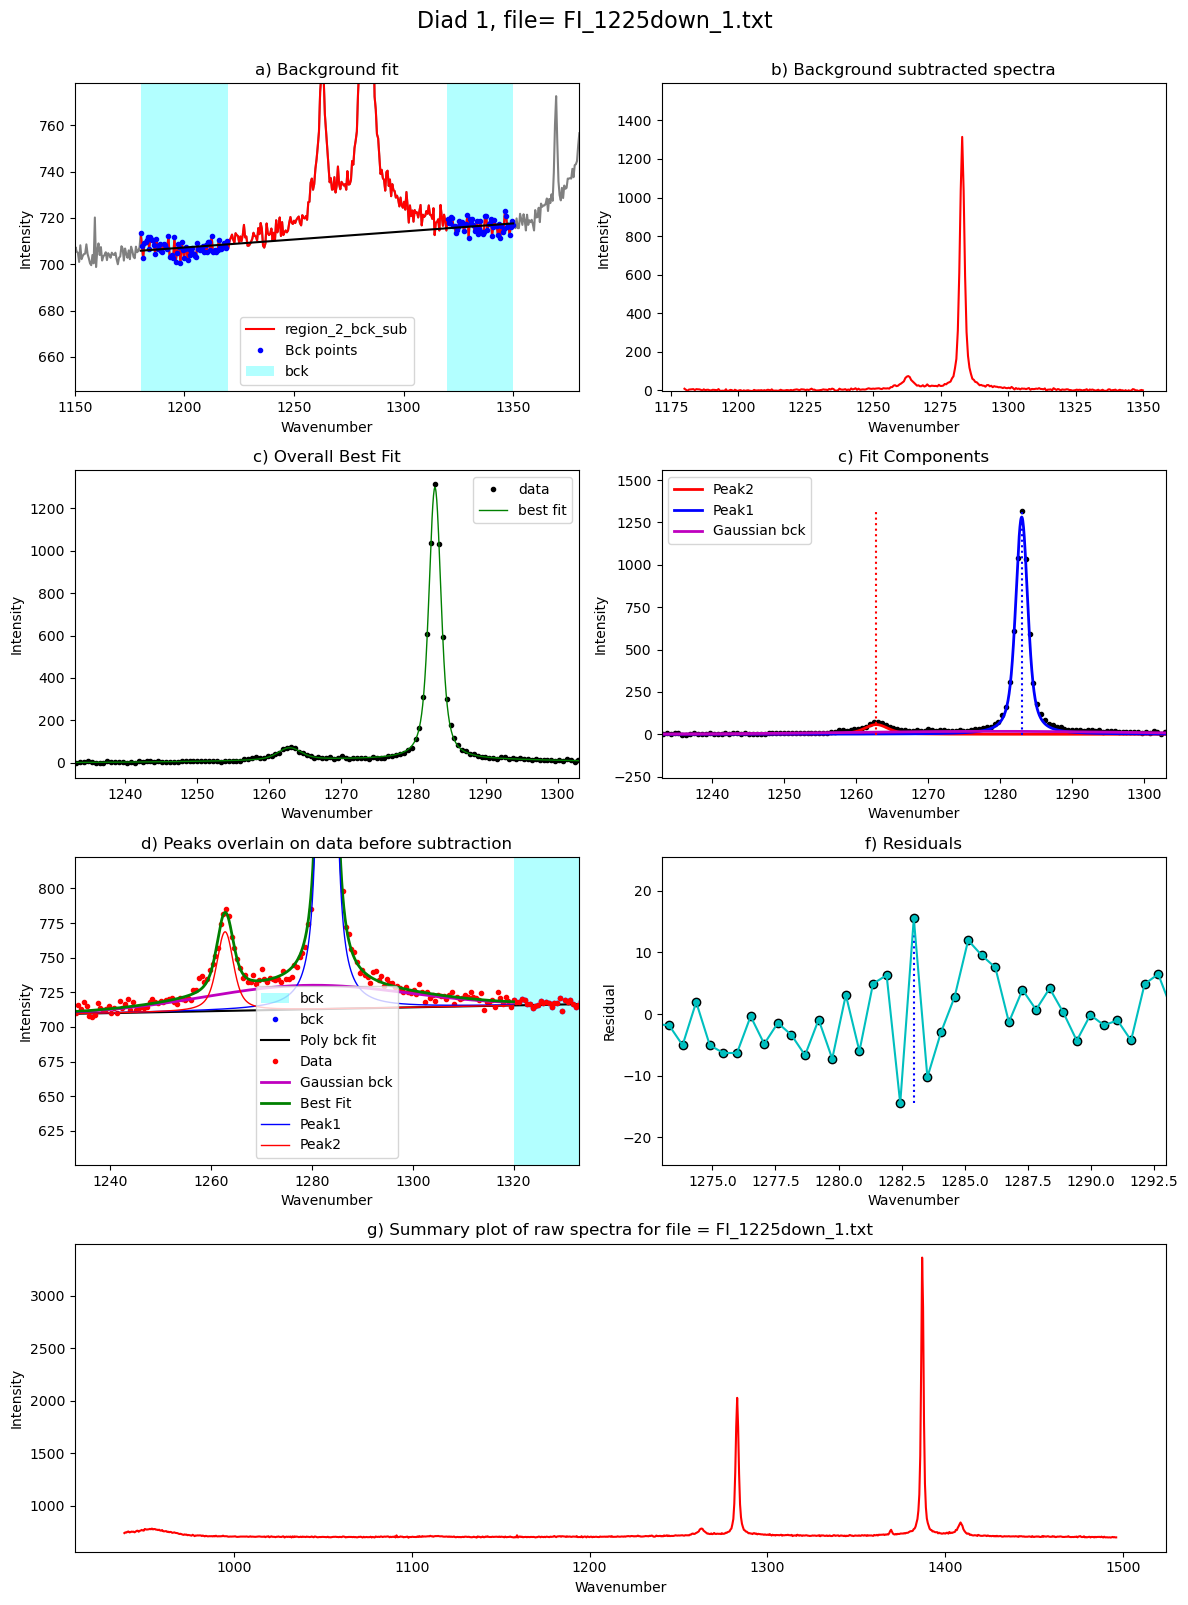

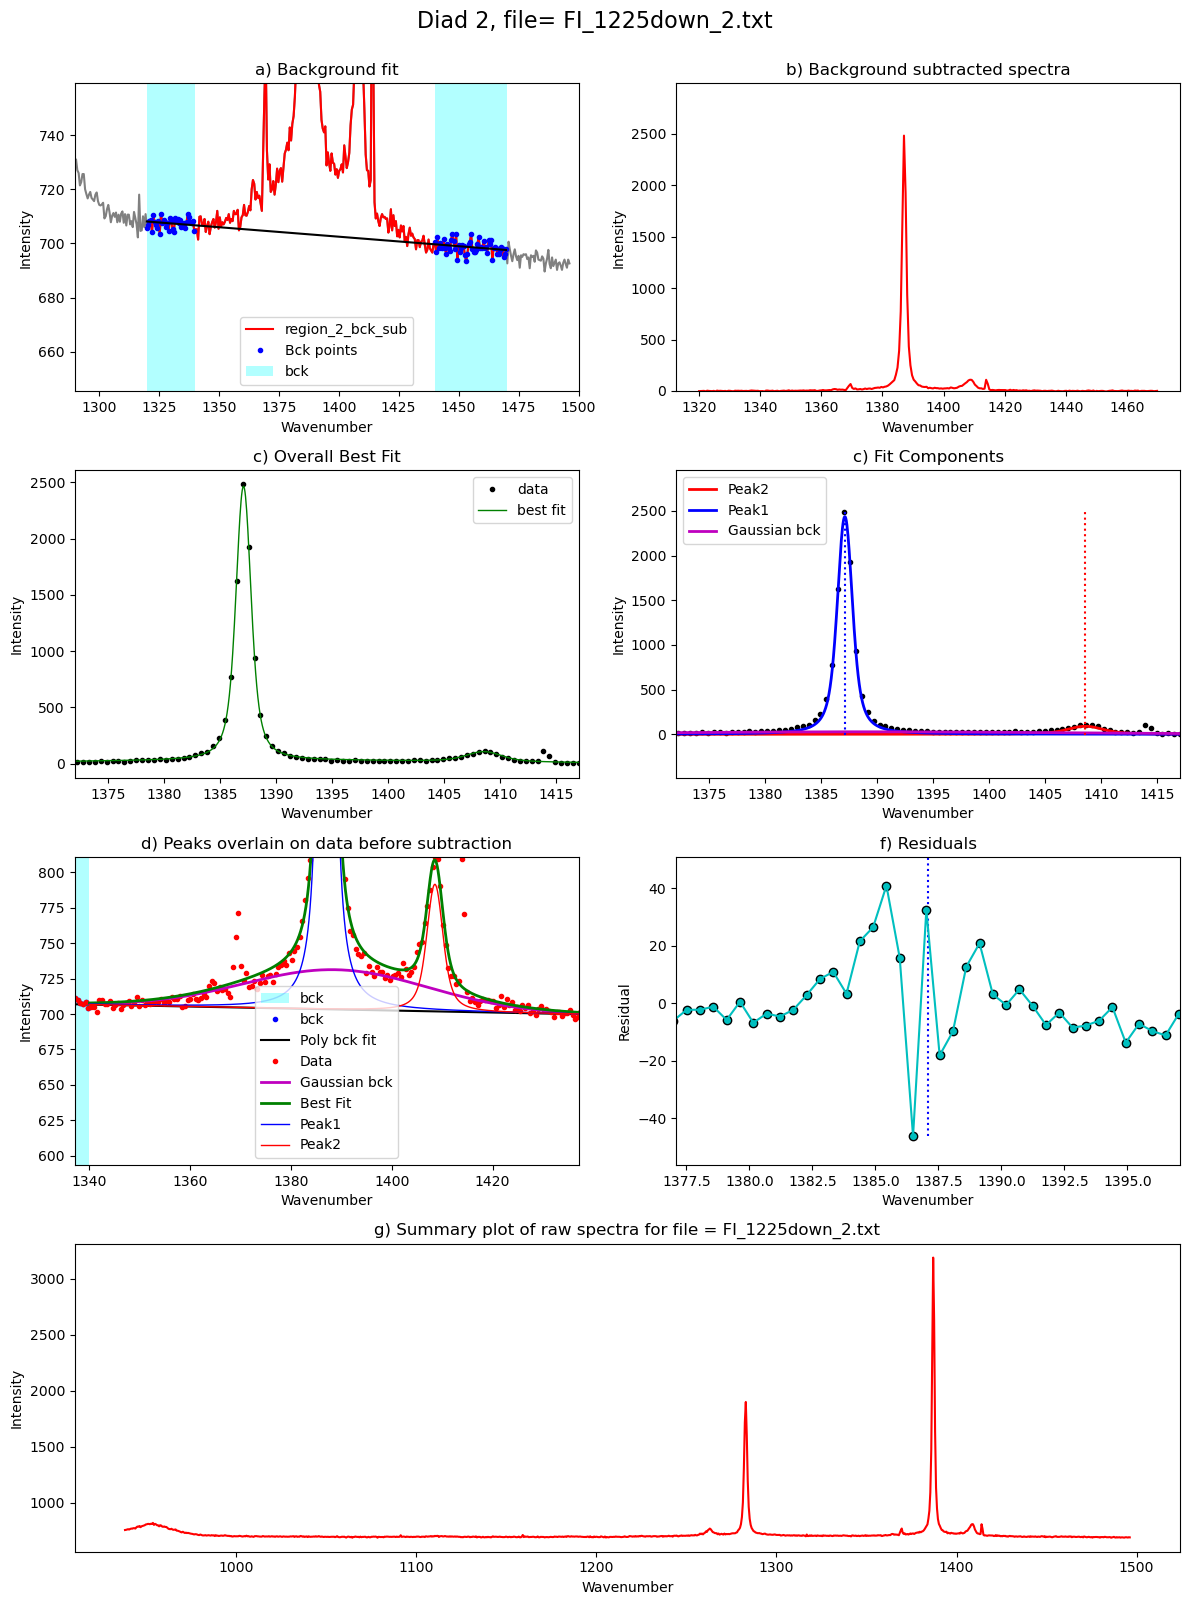

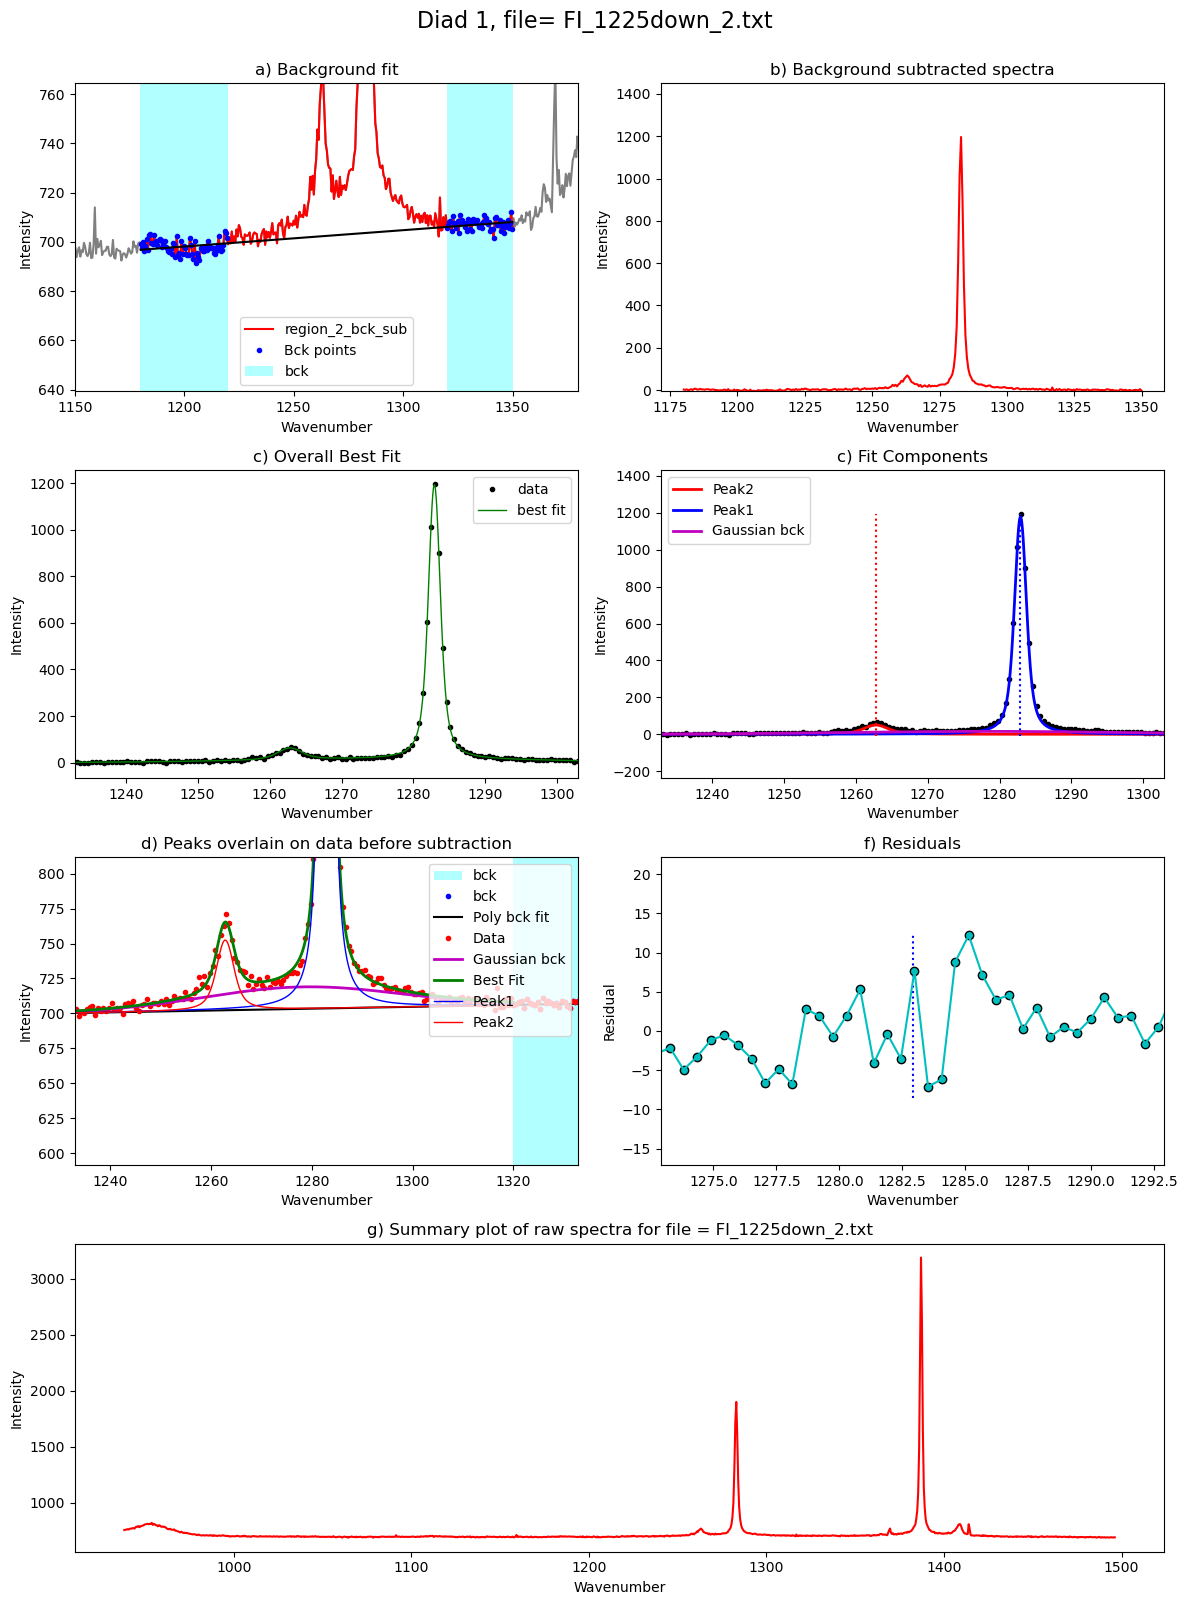

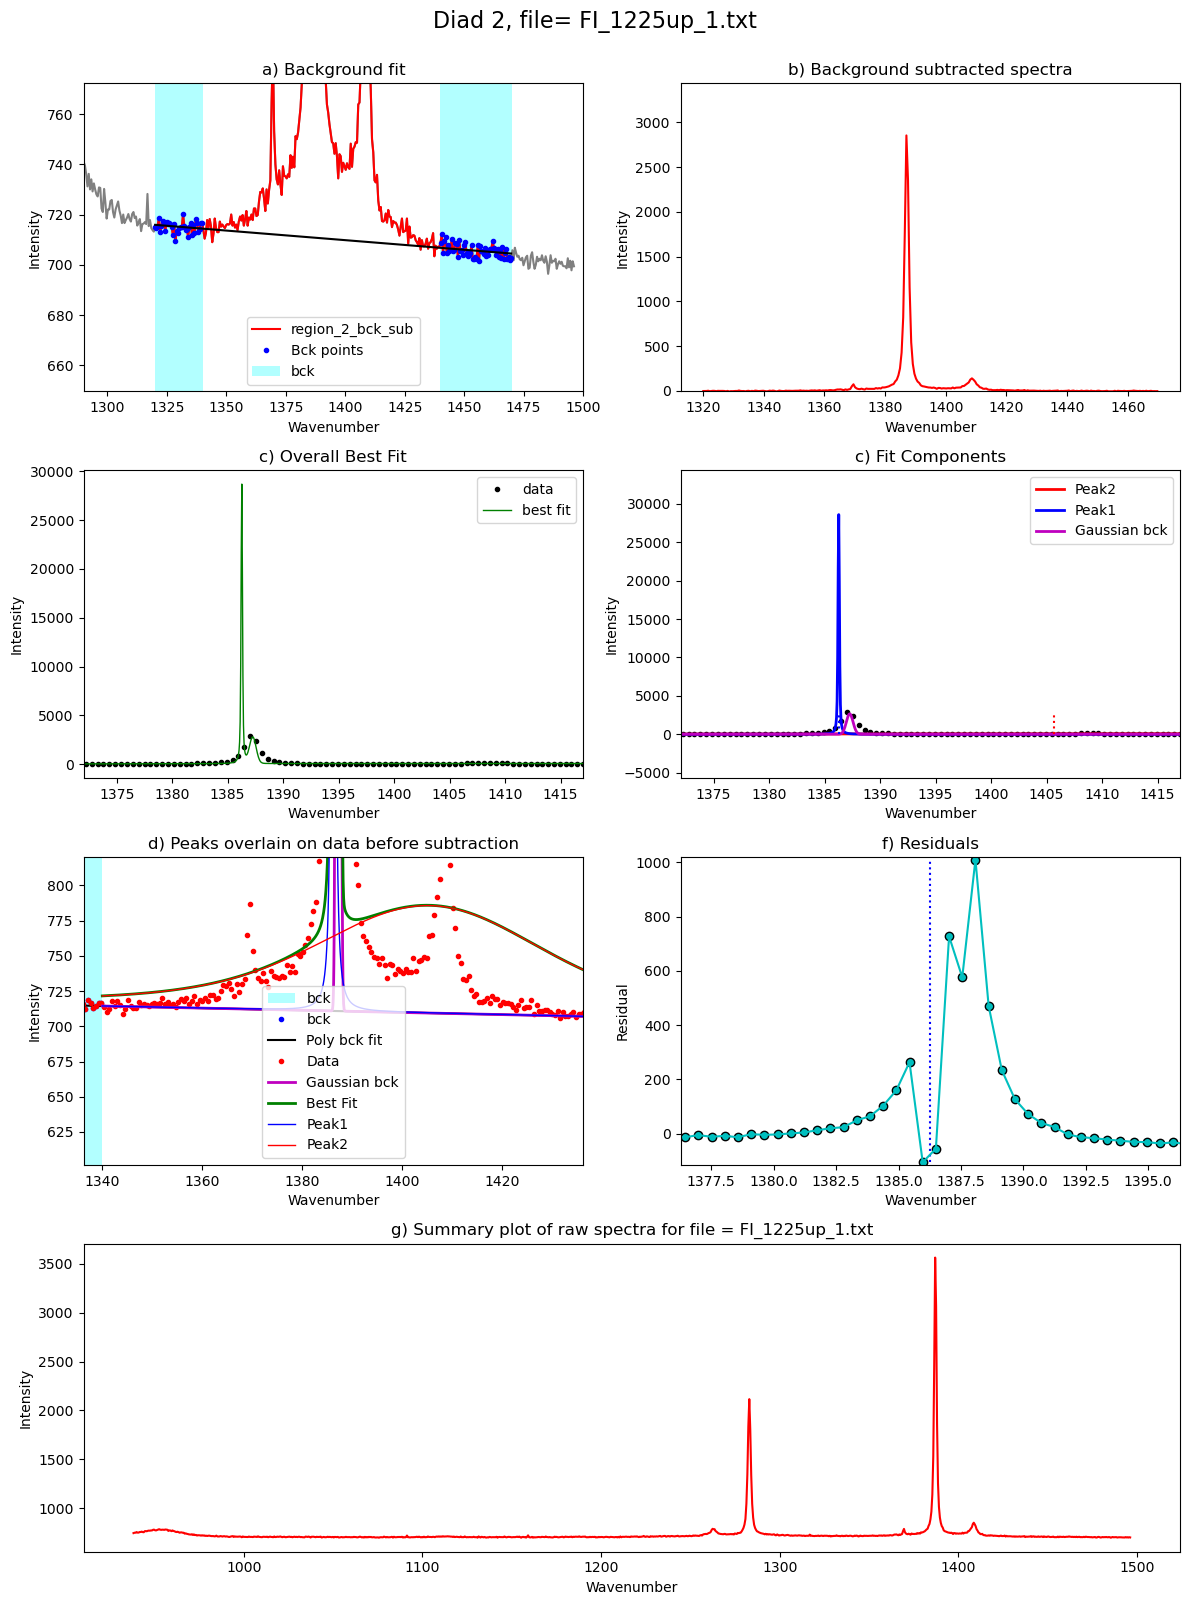

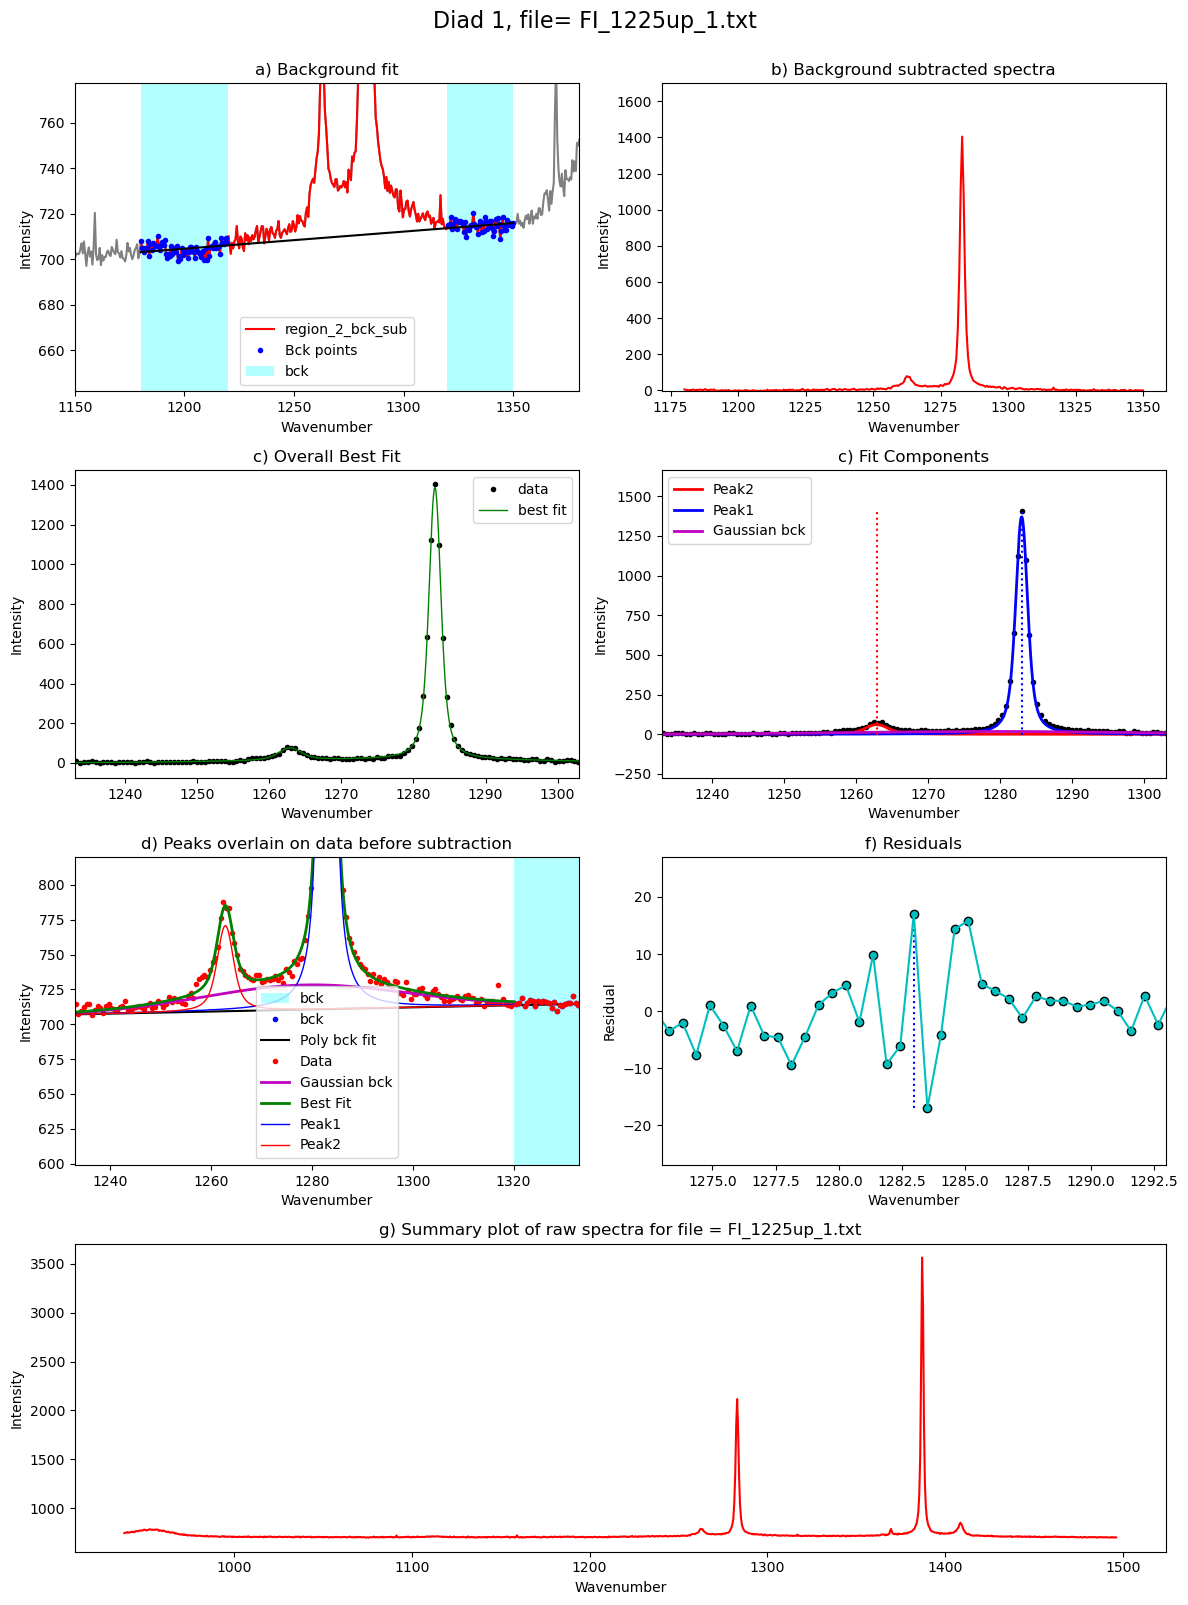

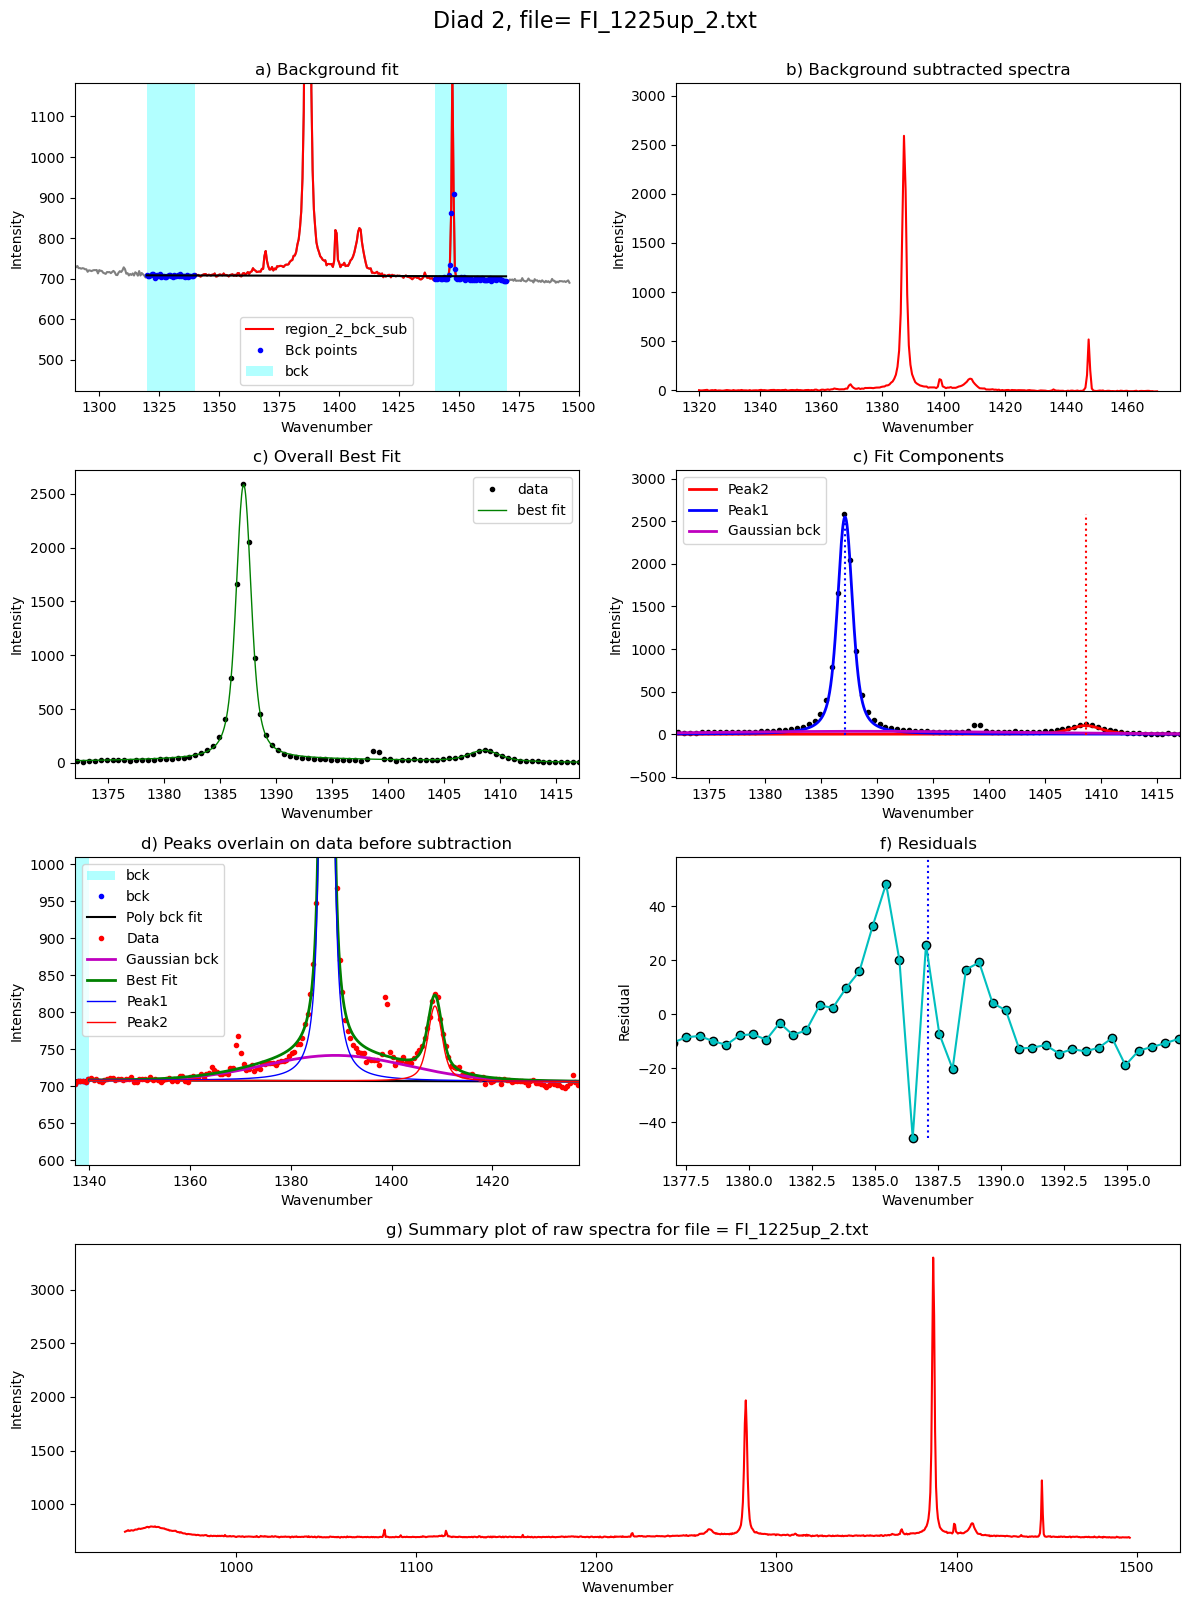

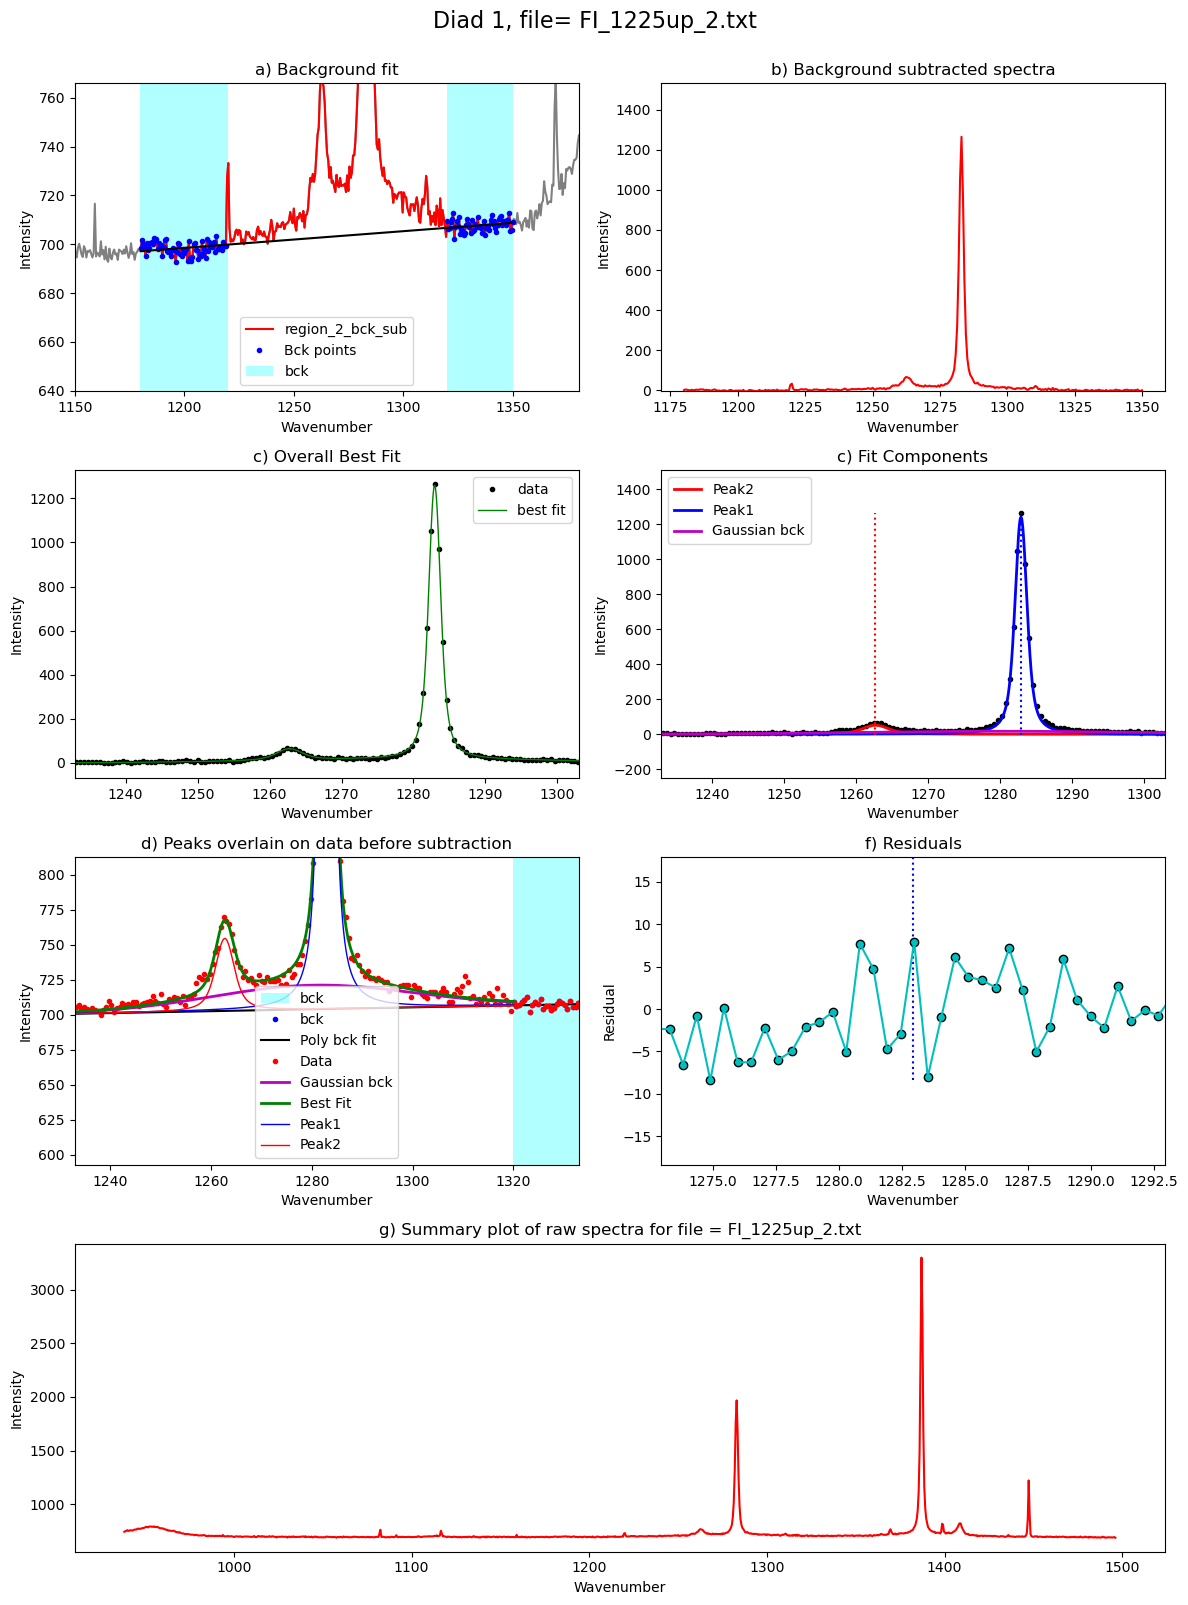

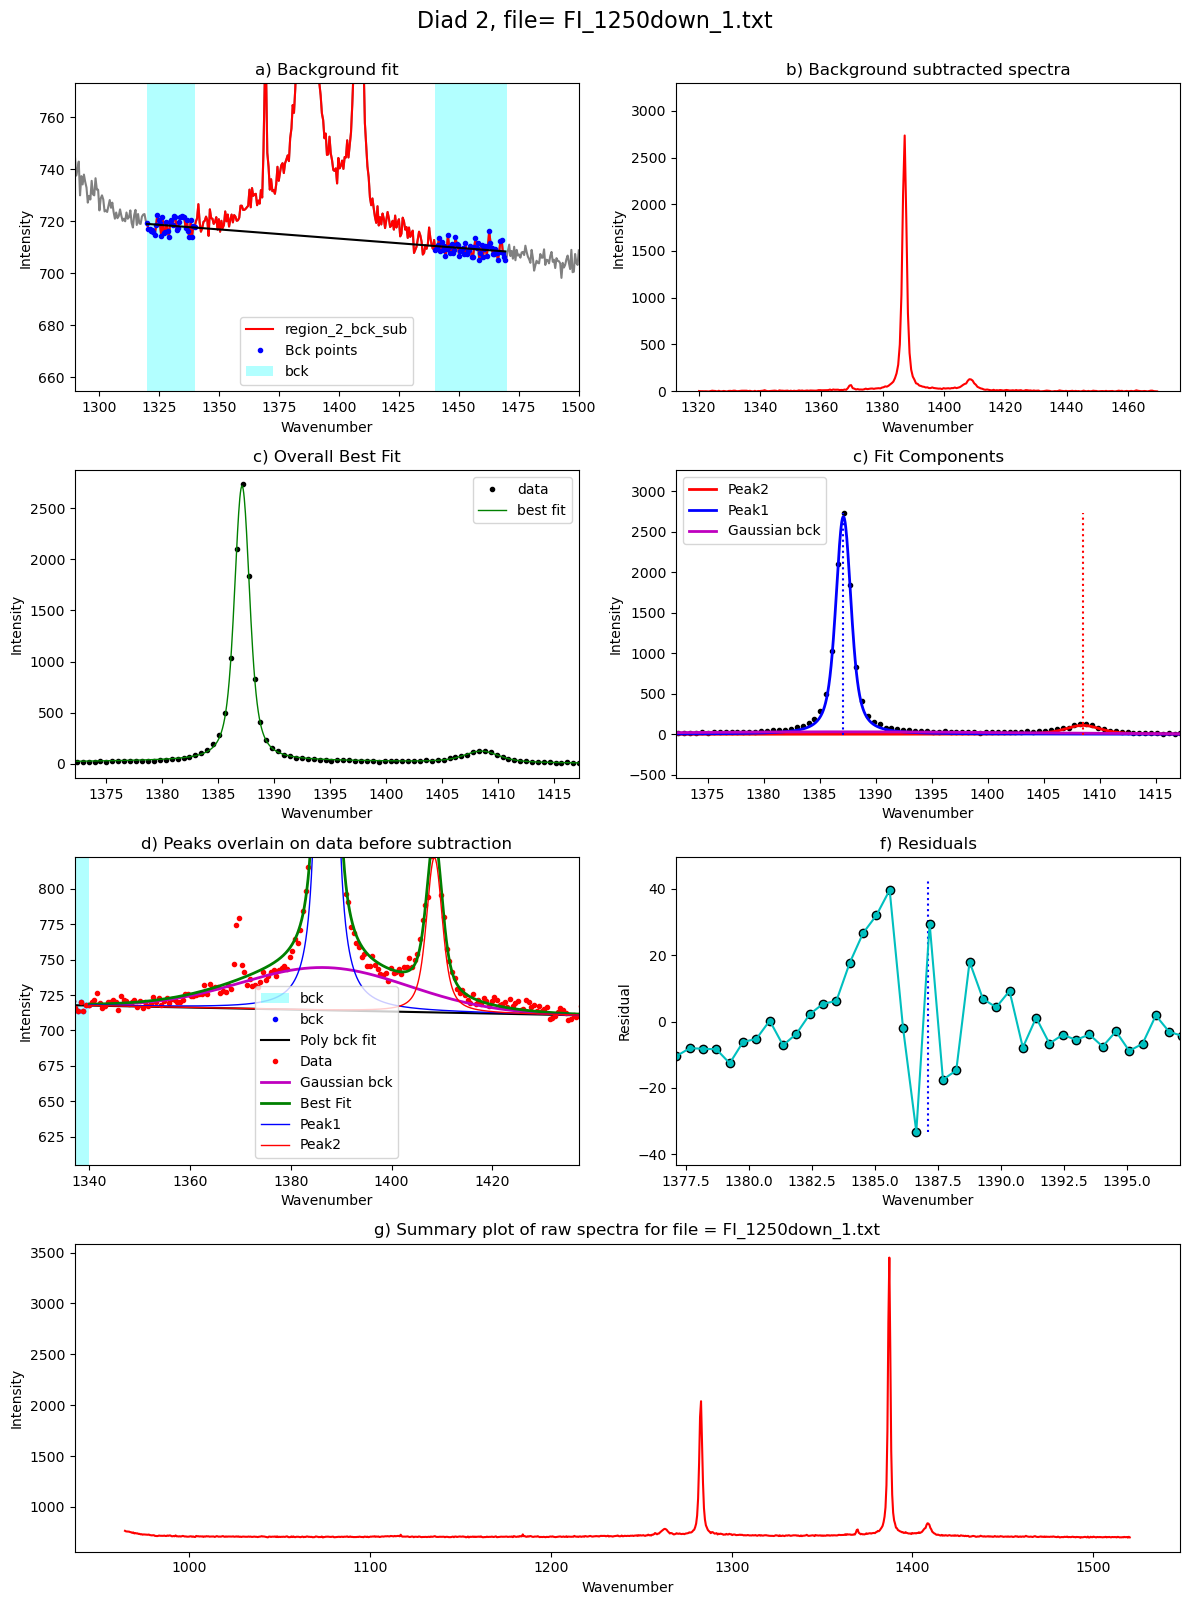

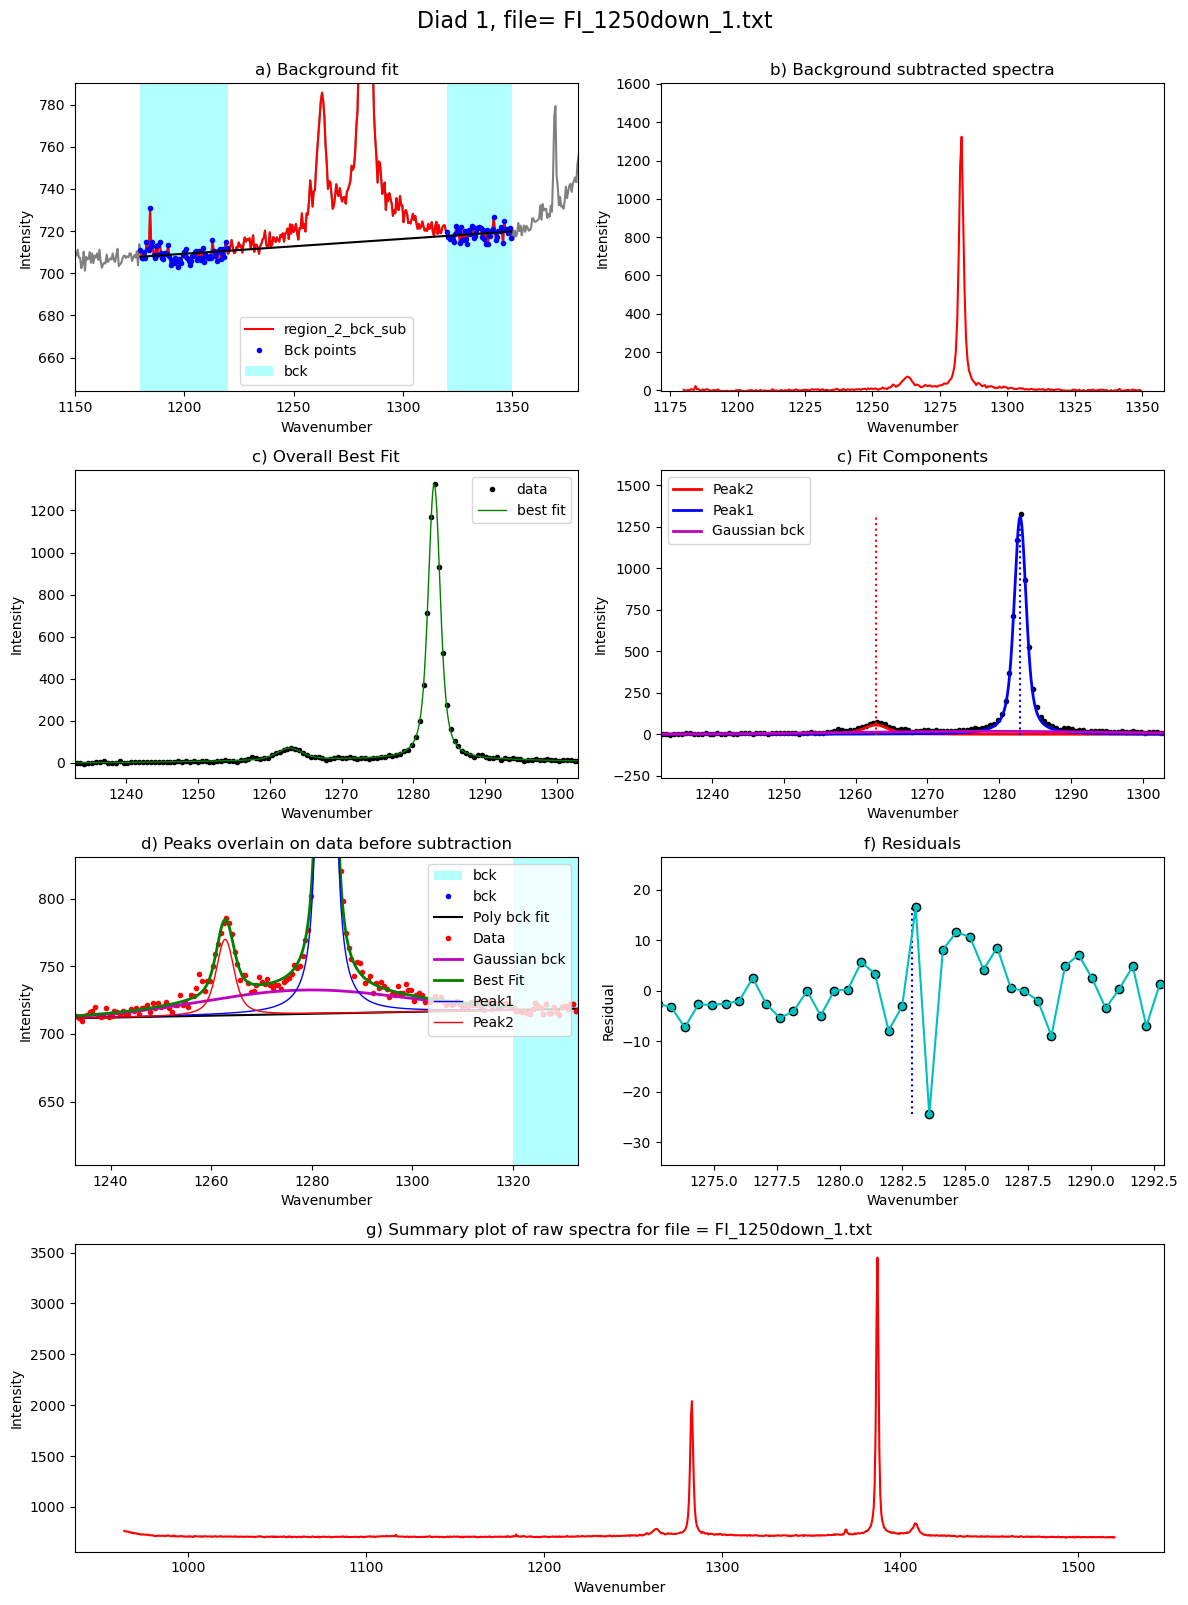

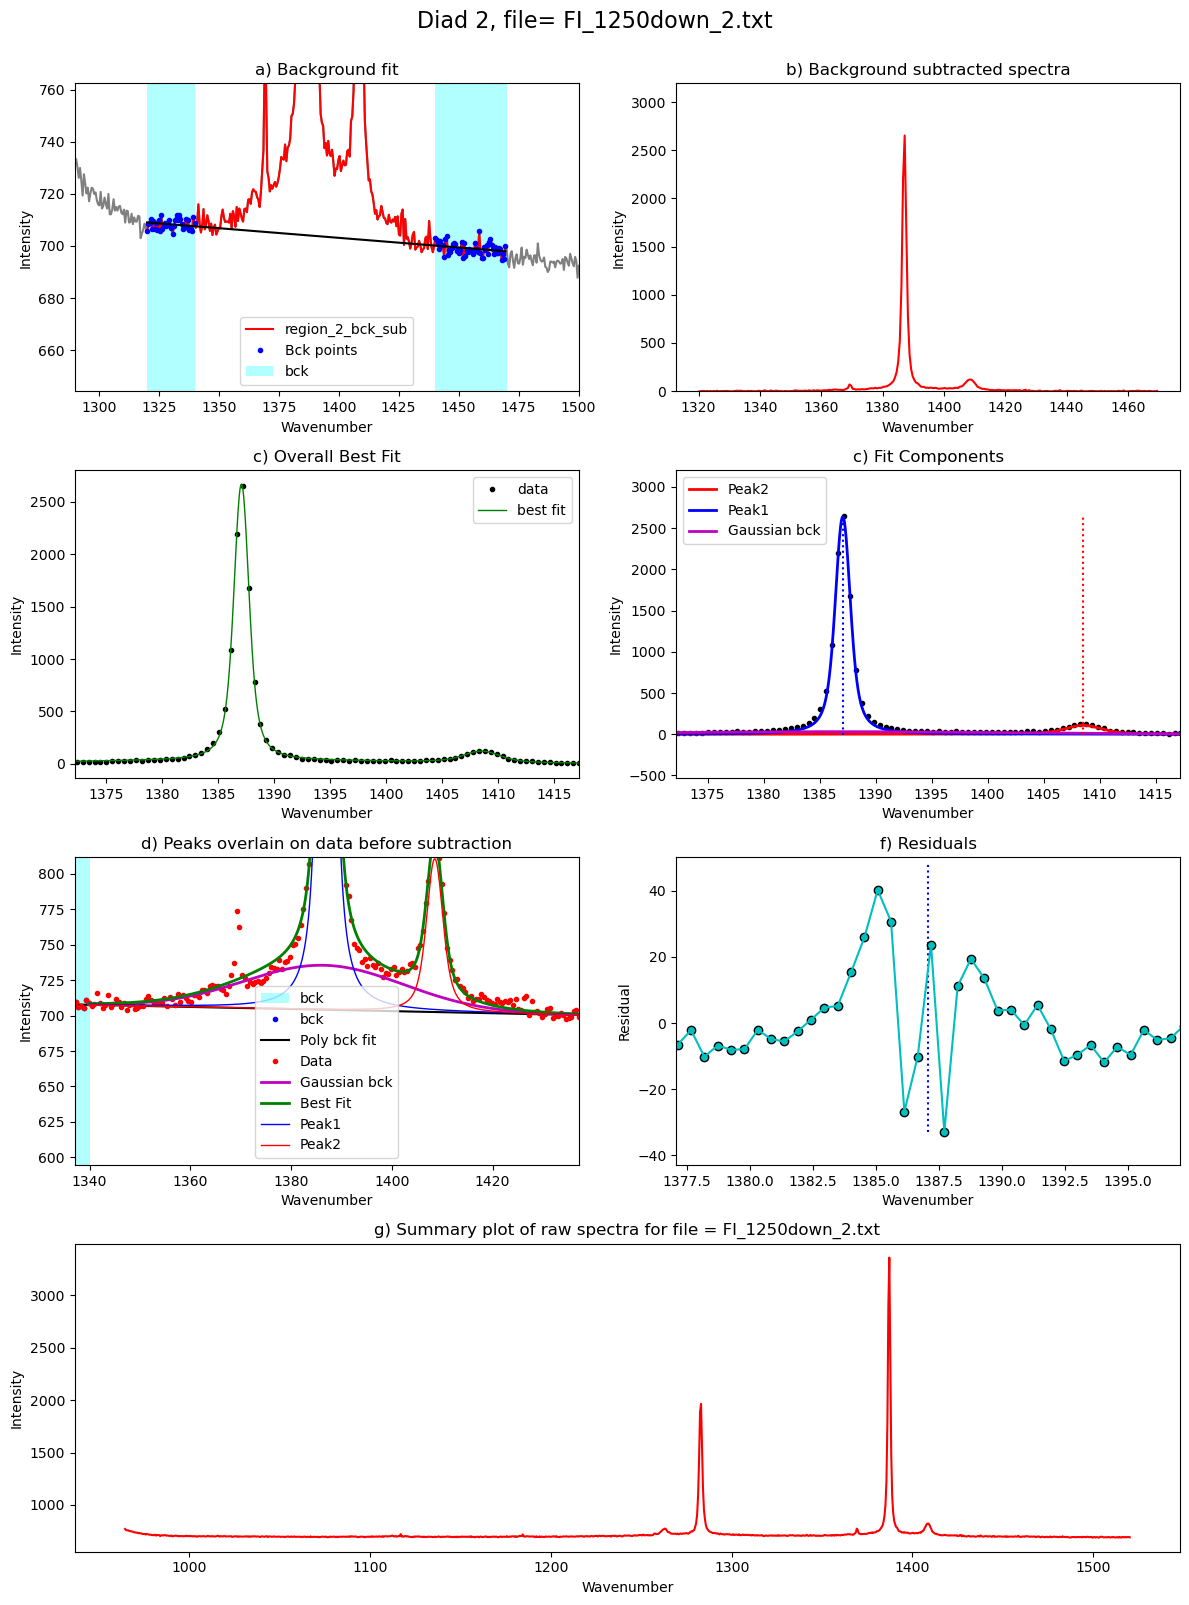

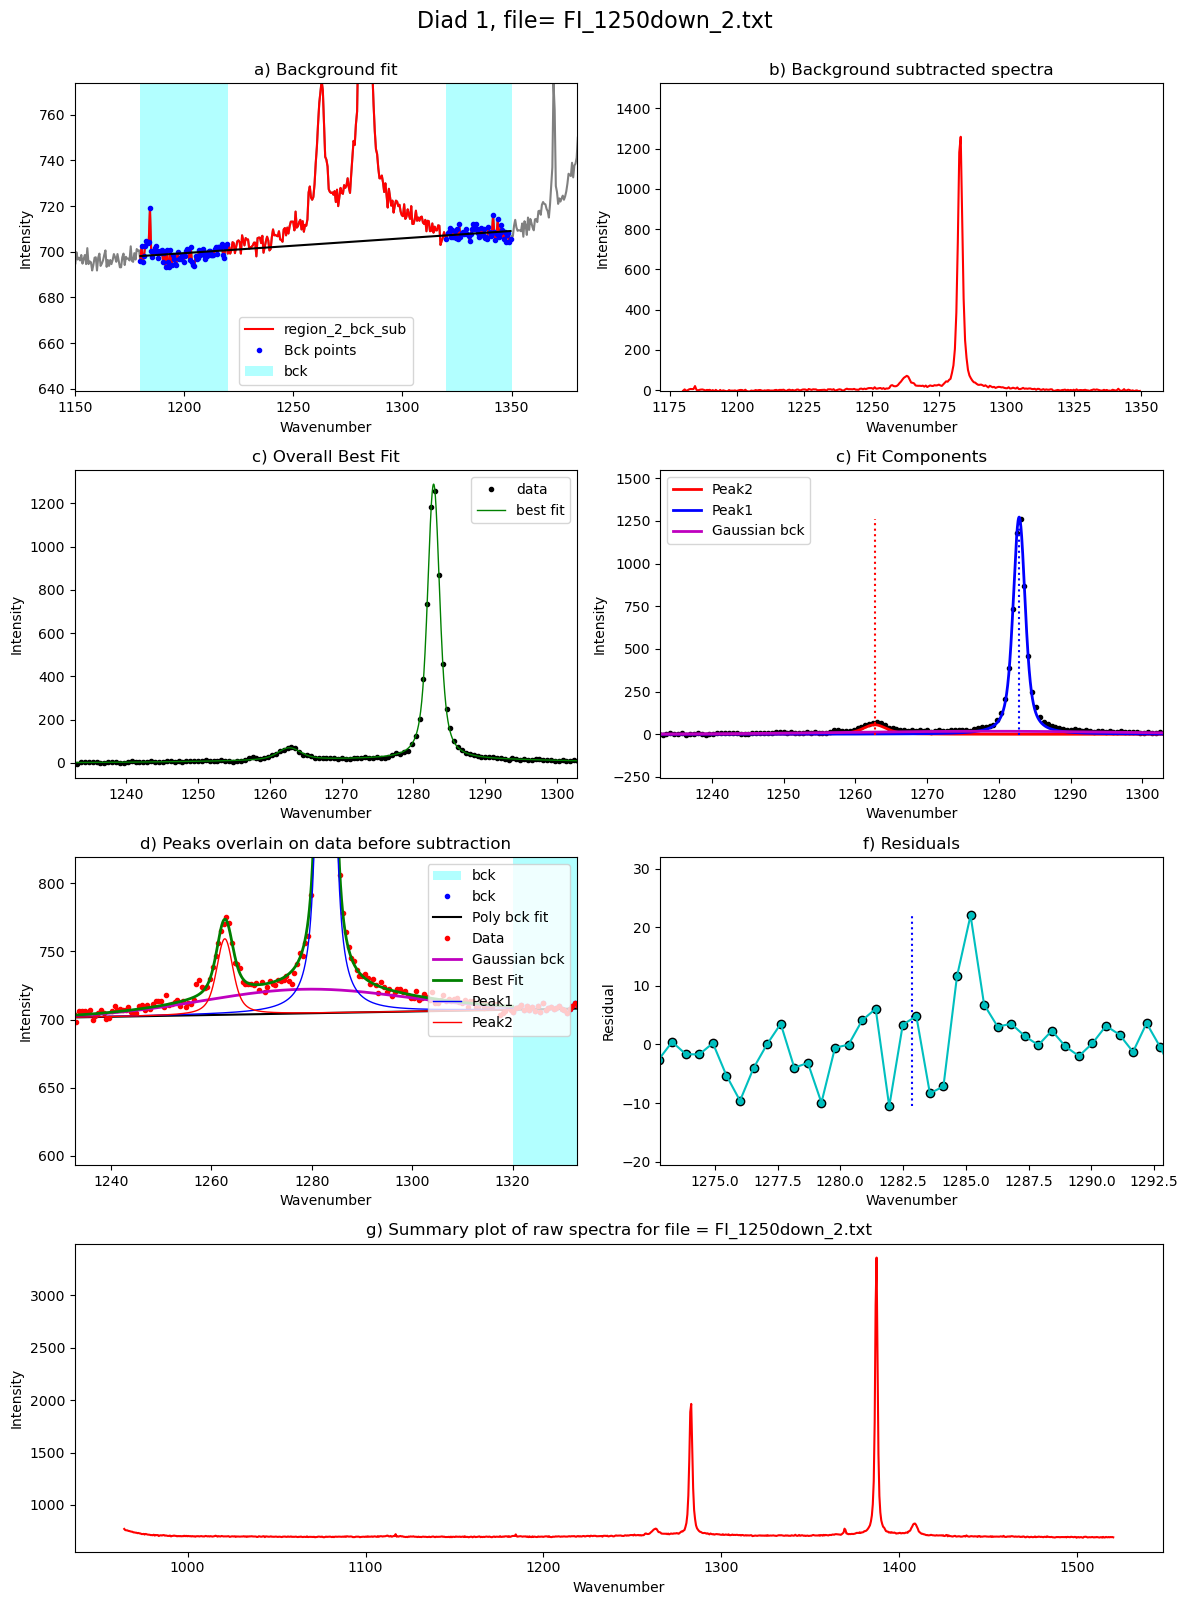

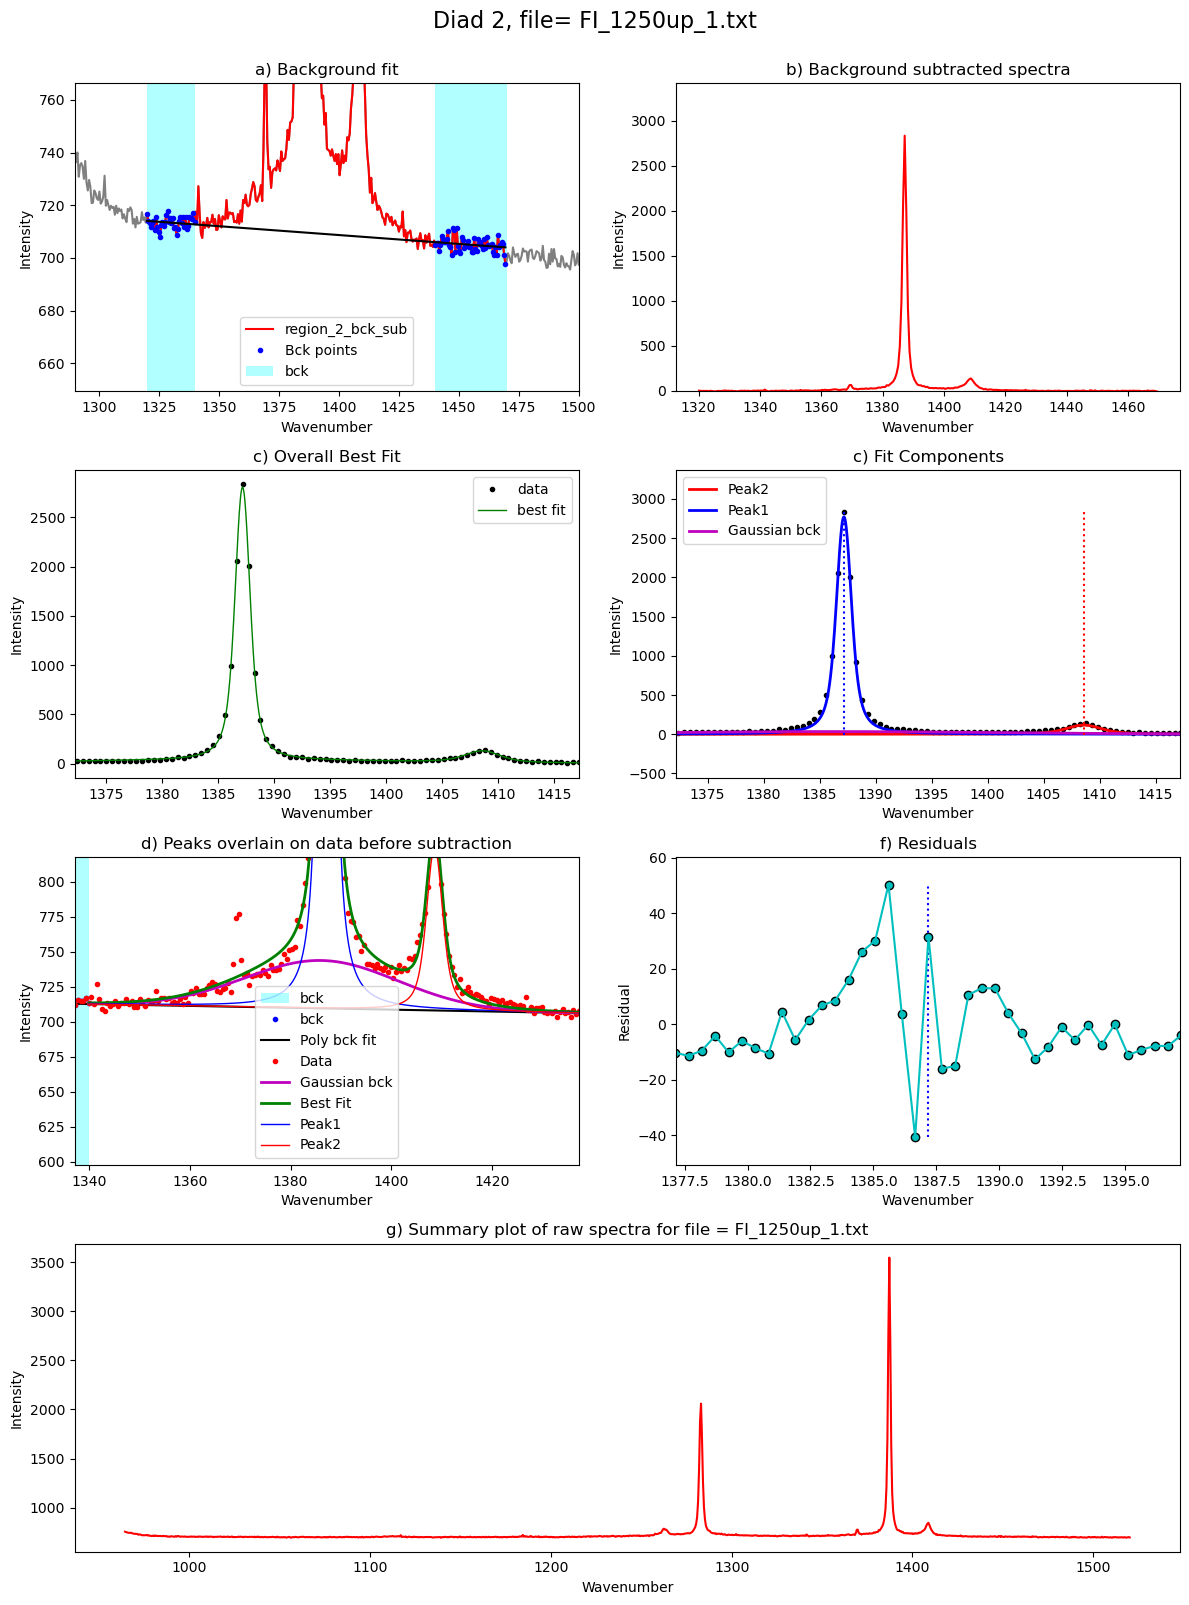

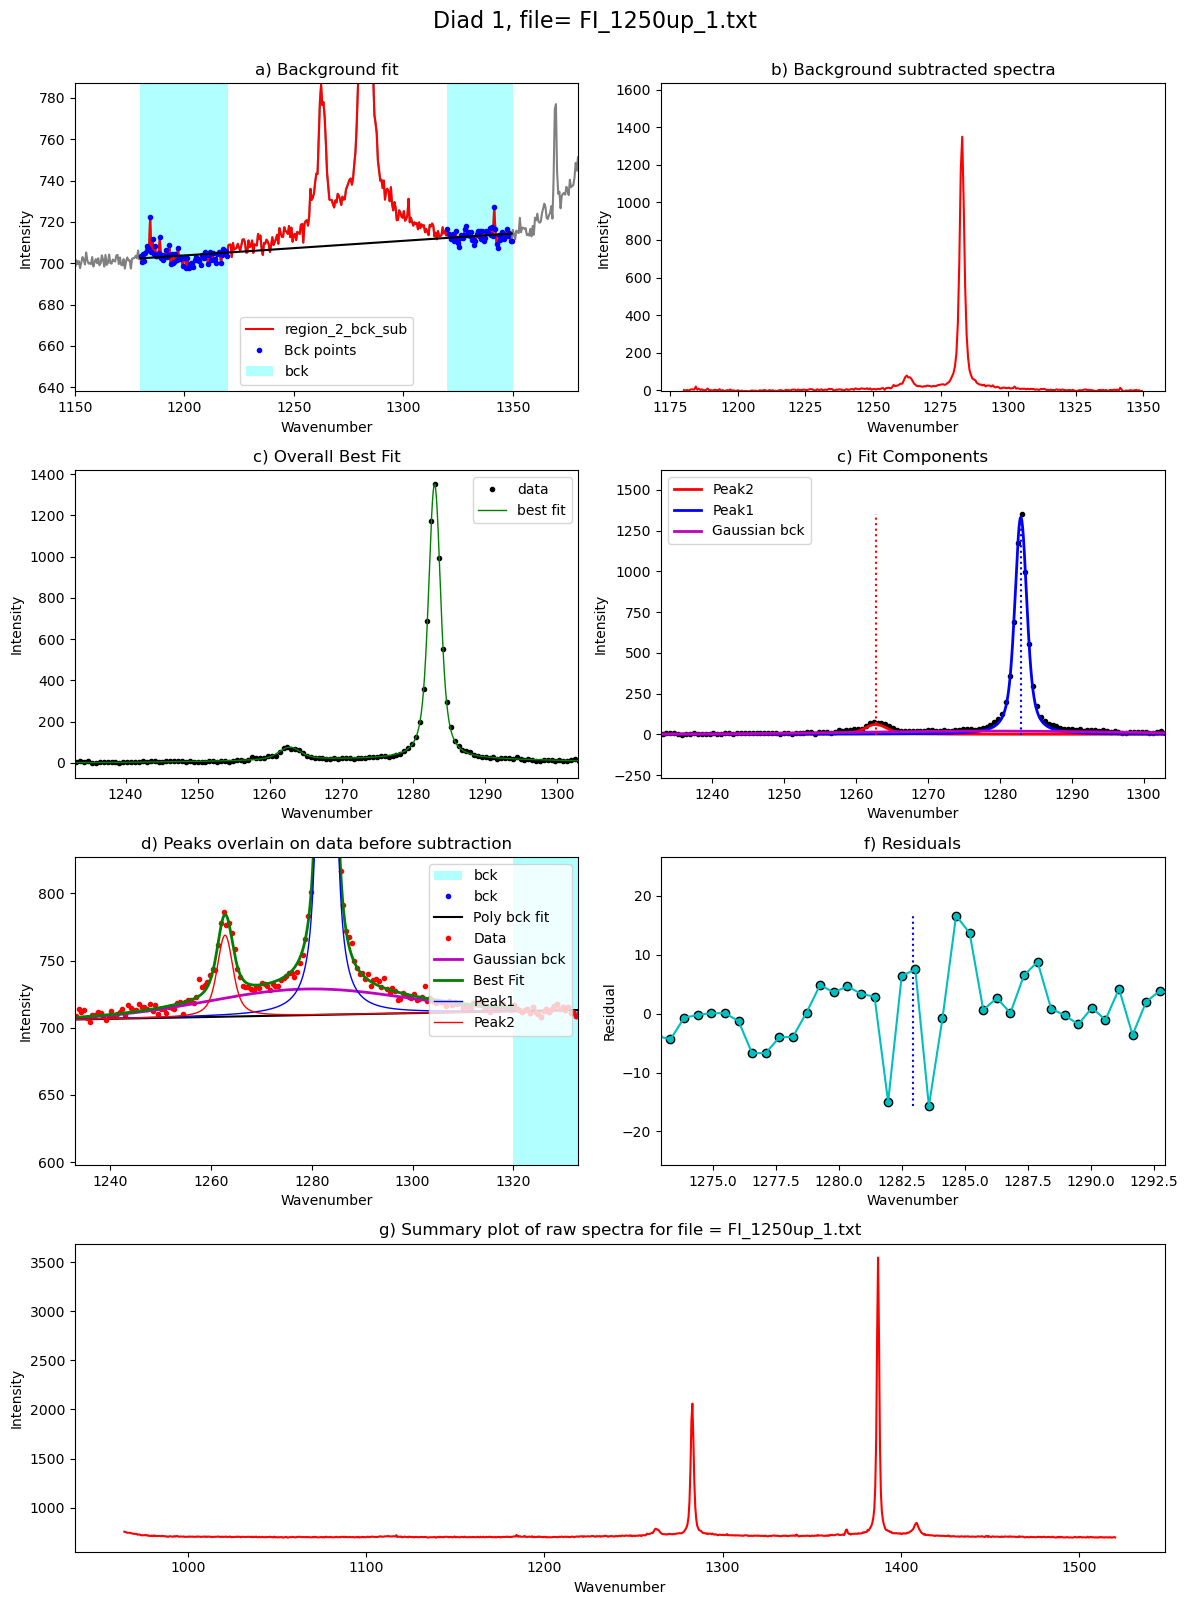

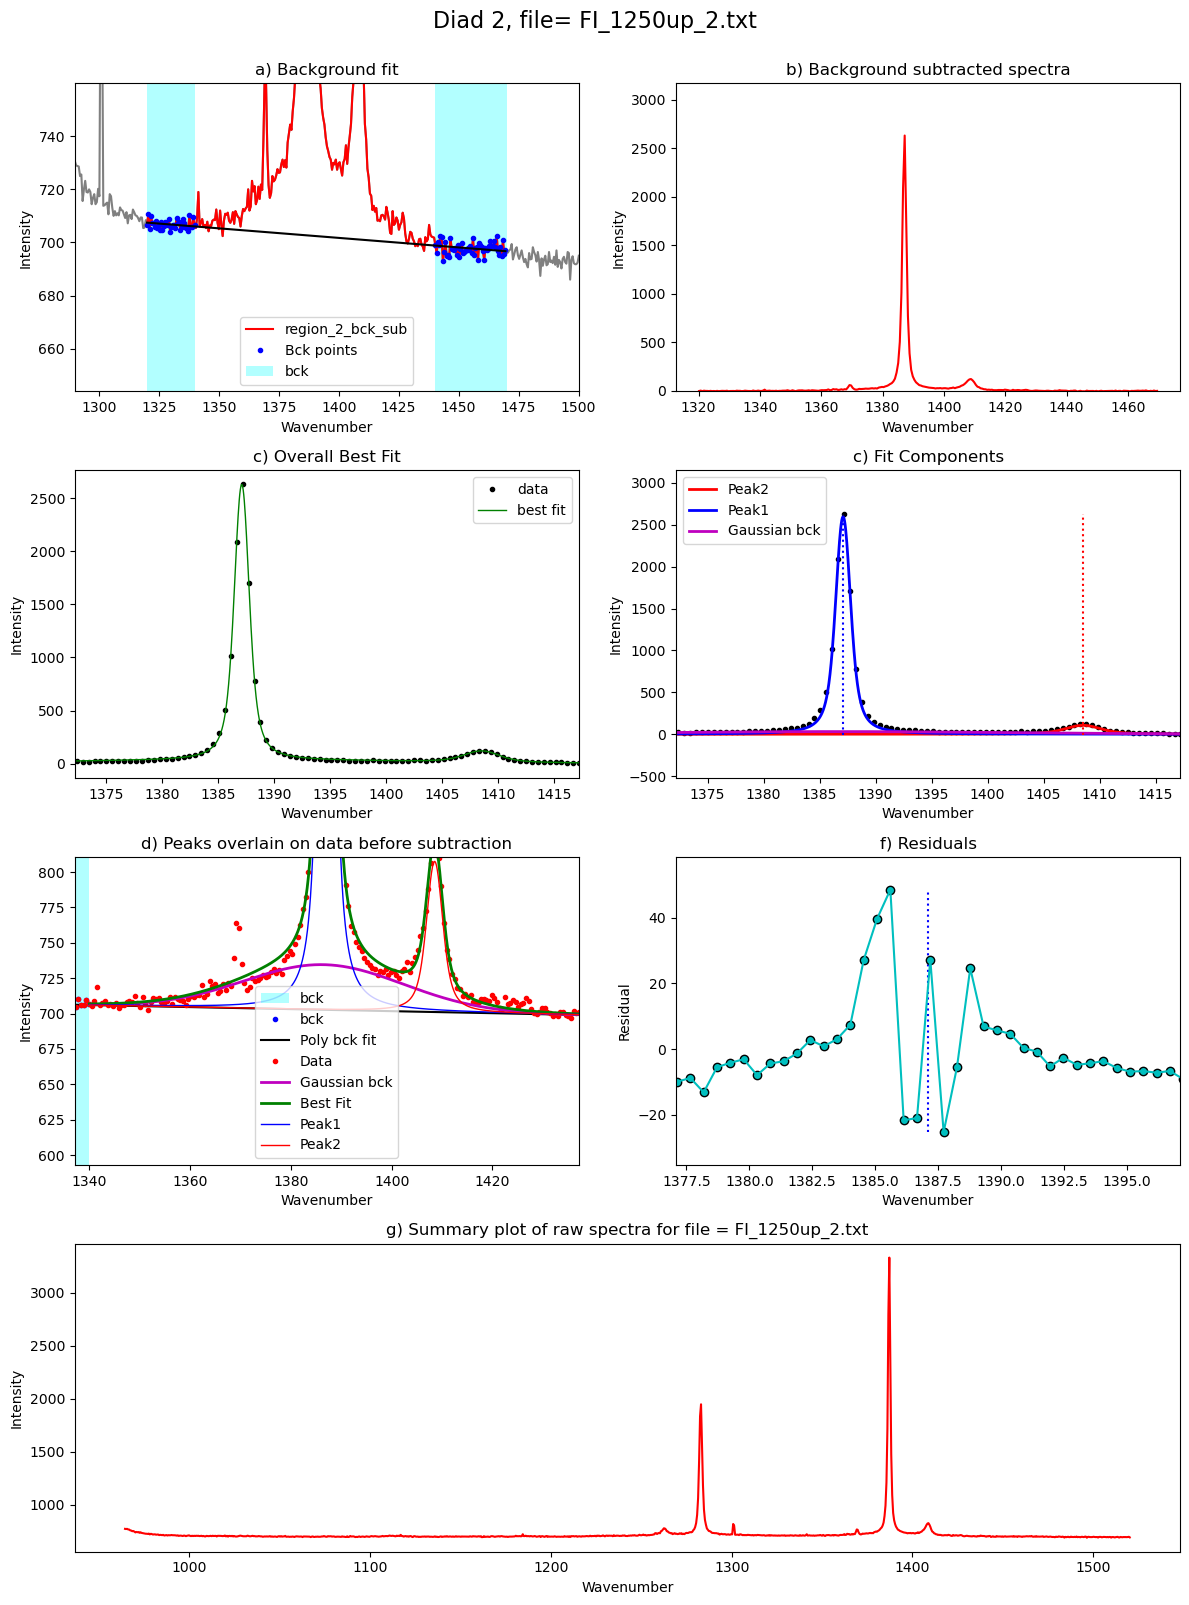

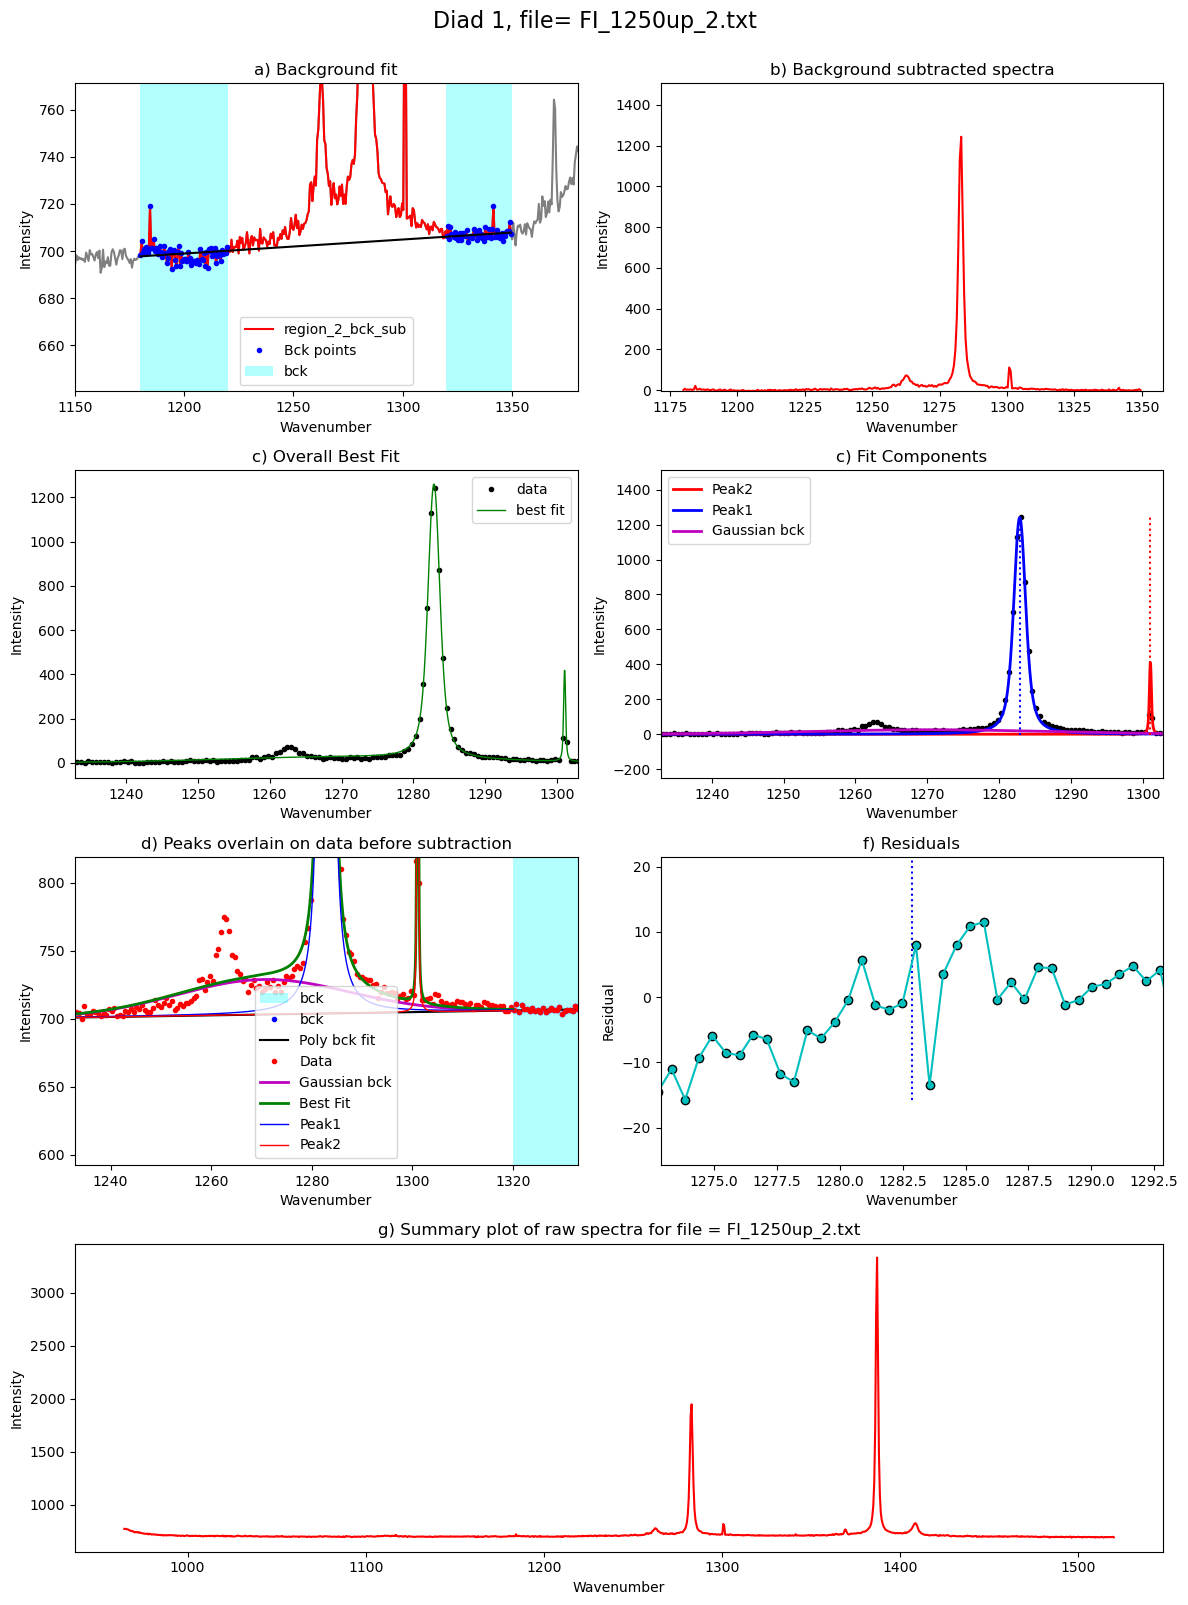

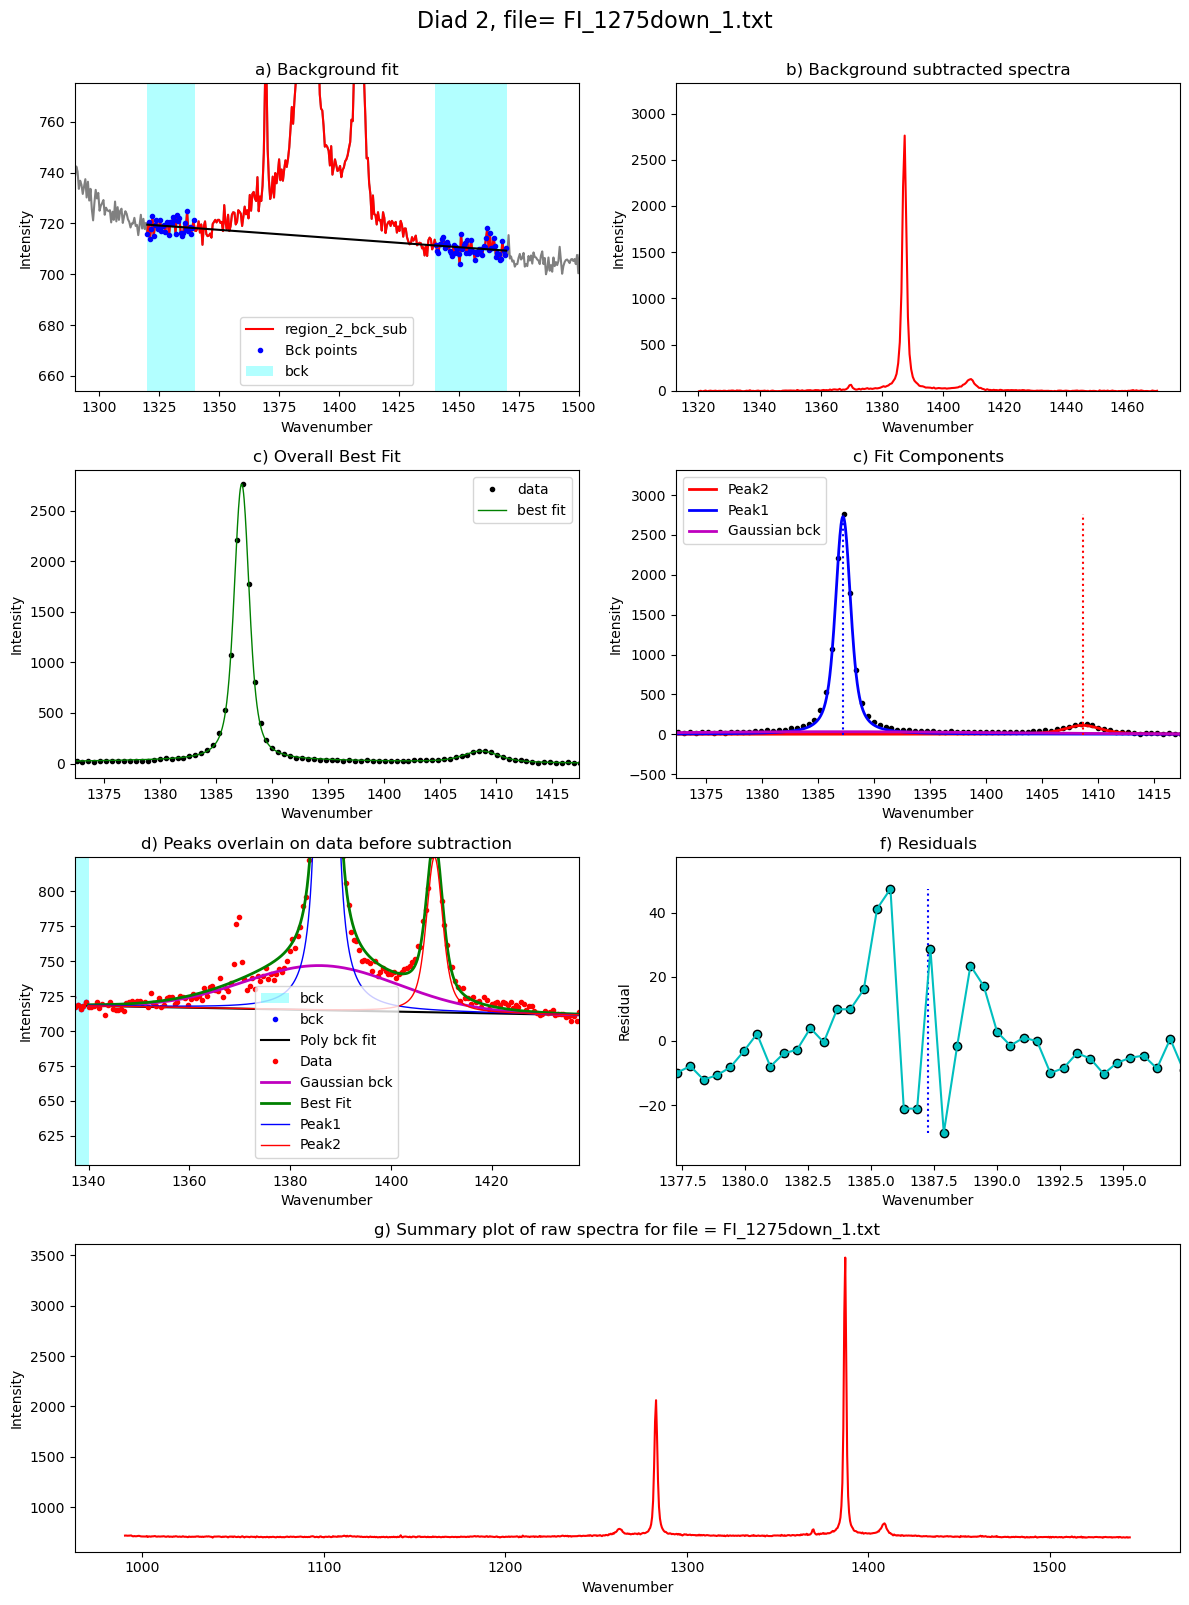

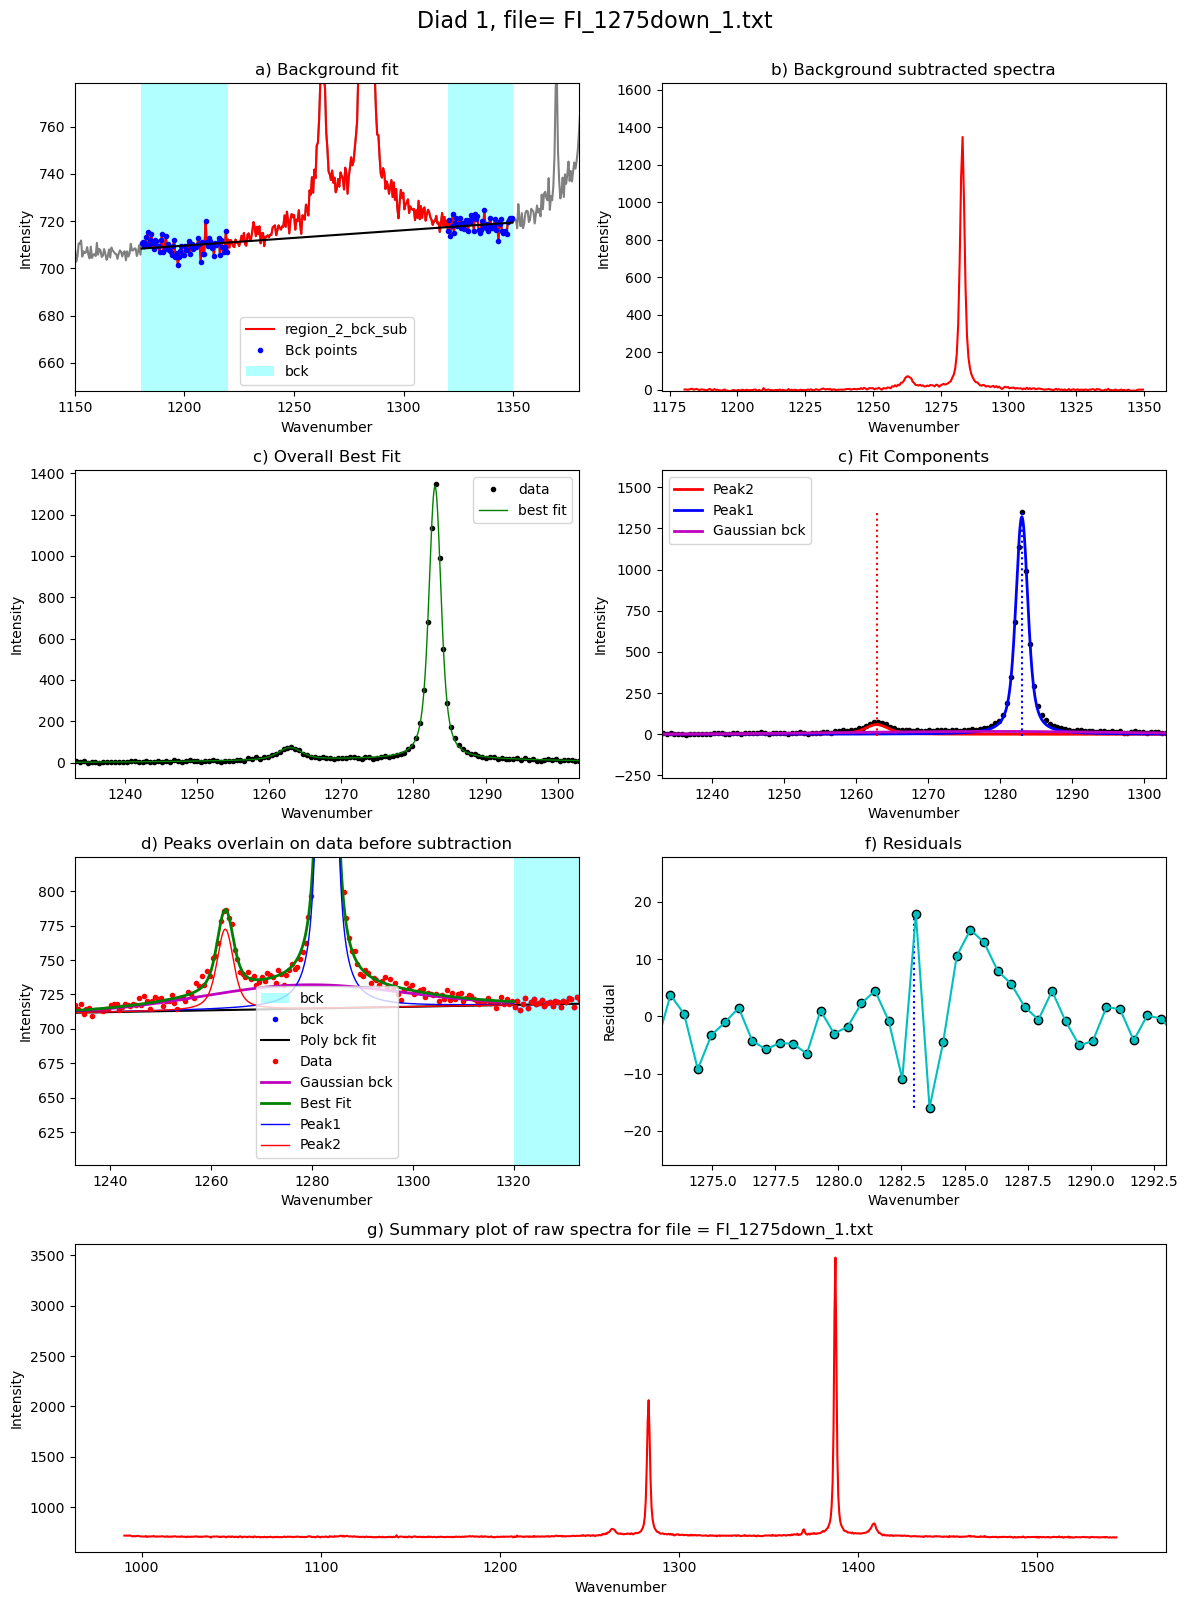

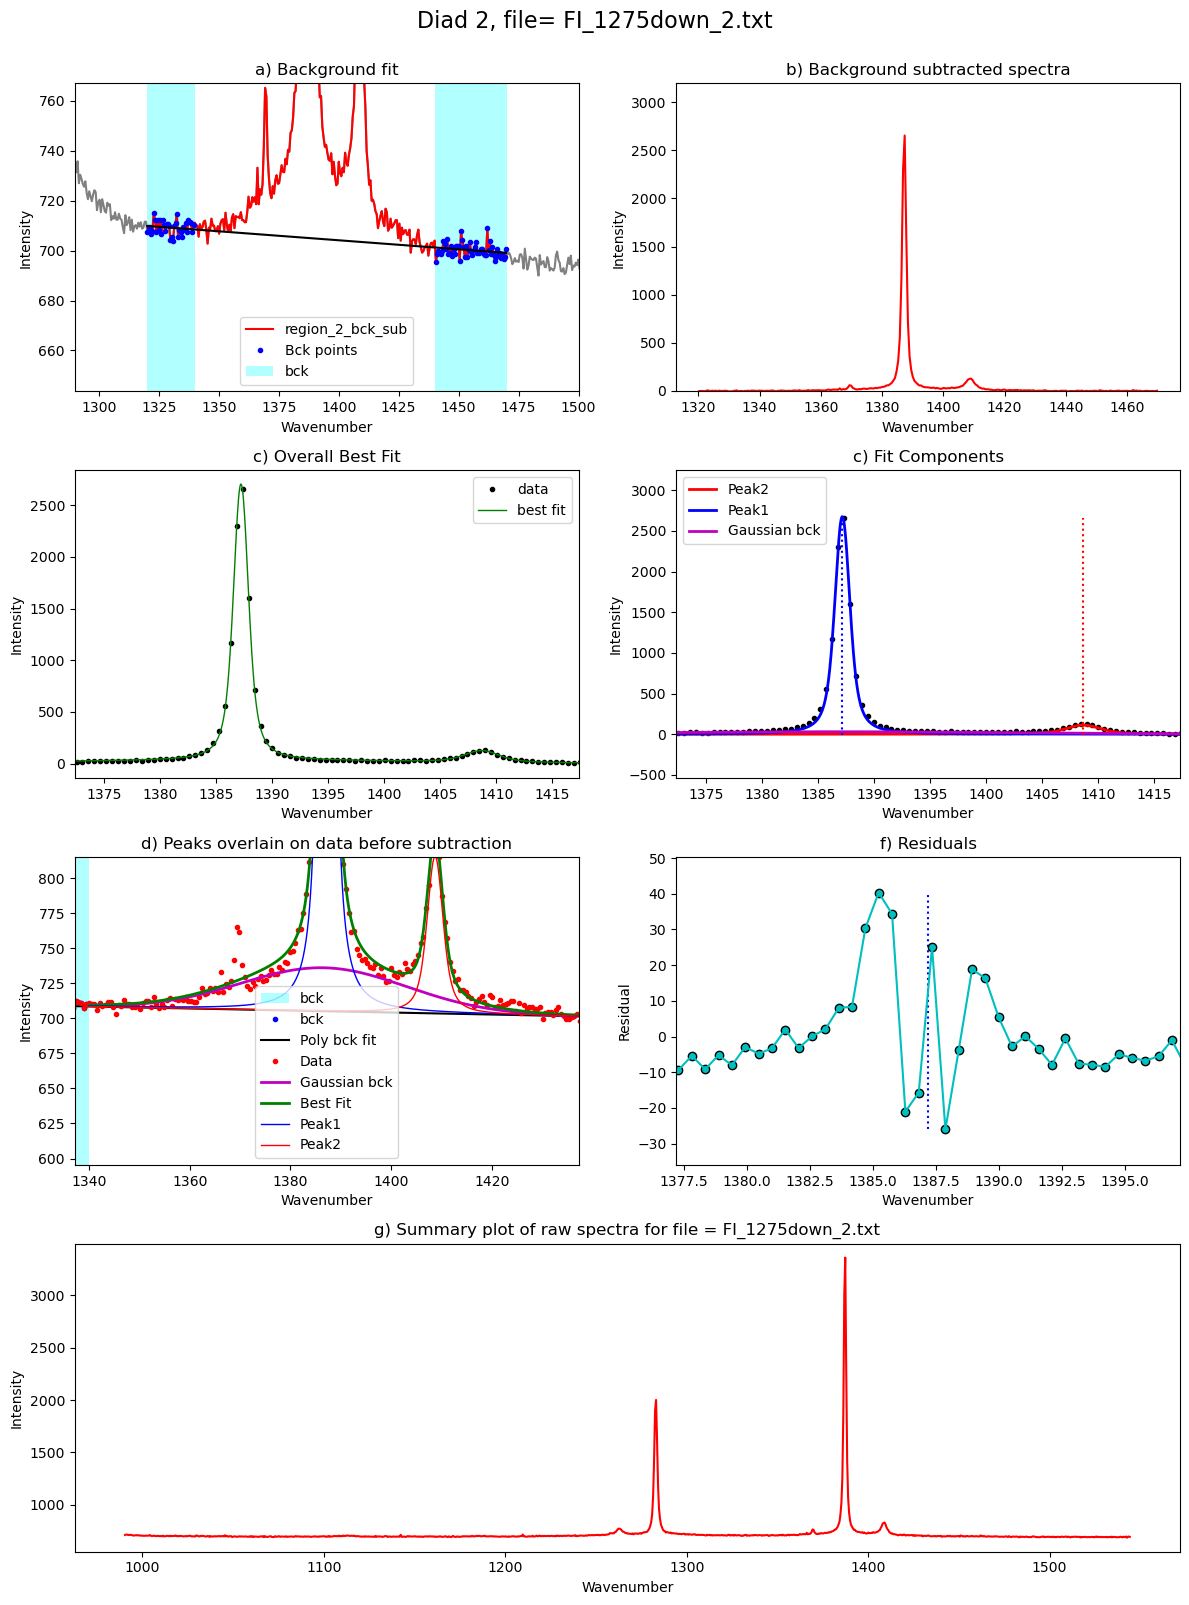

In [42]:
from tqdm import tqdm
plot_figure=True # Means doesnt make figures, lot faster. 
save_excel=True # Saves to excel
save_clipboard=True # Copies to clipboard

df = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_files))):
    
    filename=Diad_files[i]

    
    diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config,
            path=mypath, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, 
    n_peaks_diad2=n_peaks_diad2, plot_figure=False)

    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
        config2=diad_id_config, peak_pos_voigt=diad2_peaks,
    path=mypath, filename=filename, filetype=filetype)
    
    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype)
    
    data=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, path=mypath,
Diad2_fit=Diad2_fit)
 

    df = pd.concat([df, data], axis=0)
df2=df.reset_index(drop=True)

In [43]:
df2

NameError: name 'df2' is not defined

In [87]:
df2_filt=df2.loc[df2['Diad2_Area']<2000]

## Extracting metadata for these diads

In [88]:
meta_path=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\High_Density_Looping_Run\Metadata'
# Find files


# Put the common string you can in all your Ne lines here
ID_str='_'
file_ext_meta='txt' # Will only take files of this type 
exclude_str='Ne' # Will exclude files of this type, sometimes images have same name
prefix=None # Leave as none unless witec appended a number
Ne_files_meta=pf.get_diad_files(path=mypath, file_ext=file_ext, exclude_str='Ne',
                            exclude_str_2='ne')

Ne_files_meta


exclude type
.png


['Fo1-1185down.txt',
 'Fo1-1200down.txt',
 'Fo1-1200up.txt',
 'Fo1-1225down.txt',
 'Fo1-1225up.txt',
 'Fo1-1250up.txt',
 'Fo1-1300down.txt',
 'Fo1-1300up.txt',
 'Fo1-1325down.txt',
 'Fo1-1325up.txt']

In [89]:
meta=pf.stitch_metadata_in_loop(path=meta_path, Allfiles=Ne_files_meta, prefix=False, trupower=True)

working on fileFo1-1185down.txt
working on fileFo1-1200down.txt
working on fileFo1-1200up.txt
working on fileFo1-1225down.txt
working on fileFo1-1225up.txt
working on fileFo1-1250up.txt
working on fileFo1-1300down.txt
working on fileFo1-1300up.txt
working on fileFo1-1325down.txt
working on fileFo1-1325up.txt
Done


In [90]:
meta

filename               date  power (mW)  Int_time (s)  \
8  Fo1-1325down.txt  October 3, 2022\n      11.908          45.0   
6  Fo1-1300down.txt  October 3, 2022\n      12.000          45.0   
3  Fo1-1225down.txt  October 3, 2022\n      12.073          45.0   
1  Fo1-1200down.txt  October 3, 2022\n      12.137          45.0   
0  Fo1-1185down.txt  October 3, 2022\n      12.144          45.0   
2    Fo1-1200up.txt  October 3, 2022\n      12.145          45.0   
4    Fo1-1225up.txt  October 3, 2022\n      12.130          45.0   
5    Fo1-1250up.txt  October 3, 2022\n      12.117          45.0   
7    Fo1-1300up.txt  October 3, 2022\n      12.106          45.0   
9    Fo1-1325up.txt  October 3, 2022\n      12.119          45.0   

   accumulations  Mag (X)             duration     24hr_time  \
8            3.0     50.0  ['0h', '2m', '16s']  2:43:56 PM\n   
6            3.0     50.0  ['0h', '2m', '16s']  2:52:06 PM\n   
3            3.0     50.0  ['0h', '2m', '16s']  2:57:26 PM\n   
1            3.0     50.0  ['0h', '2m', '16s']  3:02:43 PM\n   
0            3.0     50.0  ['0h', '2m', '16s']  3:16:31 PM\n   
2            3.0     50.0  ['0h', '2m', '16s']  3:22:39 PM\n   
4            3.0     50.0  ['0h', '2m', '16s']  3:27:51 PM\n   
5            3.0     50.0  ['0h', '2m', '16s']  3:33:47 PM\n   
7            3.0     50.0  ['0h', '2m', '16s']  3:43:43 PM\n   
9            3.0     50.0  ['0h', '2m', '16s']  3:49:18 PM\n   

   sec since midnight  Spectral Center  index  
8             53036.0         1324.987      8  
6             53526.0         1299.957      6  
3             53846.0         1224.986      3  
1             54163.0         1200.009      1  
0             54991.0         1184.996      0  
2             55359.0         1200.009      2  
4             55671.0         1224.986      4  
5             56027.0         1250.004      5  
7             56623.0         1299.957      7  
9             56958.0         1324.987      9

## Stitching metadata and data together

In [91]:
meta['filename'][0]

'Fo1-1185down.txt'

In [92]:
df2['filename'][0]

'Fo1-1185down'

In [93]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, 
    suffix=False, 
   file_type='.txt')

file_m

array(['Fo1-1325down', 'Fo1-1300down', 'Fo1-1225down', 'Fo1-1200down',
       'Fo1-1185down', 'Fo1-1200up', 'Fo1-1225up', 'Fo1-1250up',
       'Fo1-1300up', 'Fo1-1325up'], dtype=object)

In [94]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False,
   file_type='.txt')
file_s

array(['Fo1-1185down', 'Fo1-1200down', 'Fo1-1200up', 'Fo1-1225down',
       'Fo1-1225up', 'Fo1-1250up', 'Fo1-1300down', 'Fo1-1300up',
       'Fo1-1325down', 'Fo1-1325up'], dtype=object)

In [95]:
# Combining them together
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

In [96]:
df_combo.head()

filename_x   Splitting   Diad1_Cent  Diad1_Area  Residual_Diad1  \
0  Fo1-1185down  102.920886  1285.530909  651.641175        2.570356   
1  Fo1-1200down  102.963233  1285.447966  622.764891        2.396269   
2    Fo1-1200up  102.963599  1285.444496  685.389051        2.197272   
3  Fo1-1225down  102.994166  1285.464037  603.693487        1.914516   
4    Fo1-1225up  102.980658  1285.470493  694.257825        2.230584   

    Diad2_Cent   Diad2_Area  Residual_Diad2  HB1_Cent  HB1_Area  ...  \
0  1388.451794   969.253076        3.306793       NaN         0  ...   
1  1388.411199   978.704557        3.401732       NaN         0  ...   
2  1388.408095  1076.056604        3.558645       NaN         0  ...   
3  1388.458203   944.049375        3.362388       NaN         0  ...   
4  1388.451151  1093.279683        3.399043       NaN         0  ...   

                date  power (mW)  Int_time (s)  accumulations Mag (X)  \
0  October 3, 2022\n      12.144          45.0            3.0    50.0   
1  October 3, 2022\n      12.137          45.0            3.0    50.0   
2  October 3, 2022\n      12.145          45.0            3.0    50.0   
3  October 3, 2022\n      12.073          45.0            3.0    50.0   
4  October 3, 2022\n      12.130          45.0            3.0    50.0   

              duration     24hr_time  sec since midnight  Spectral Center  \
0  ['0h', '2m', '16s']  3:16:31 PM\n             54991.0         1184.996   
1  ['0h', '2m', '16s']  3:02:43 PM\n             54163.0         1200.009   
2  ['0h', '2m', '16s']  3:22:39 PM\n             55359.0         1200.009   
3  ['0h', '2m', '16s']  2:57:26 PM\n             53846.0         1224.986   
4  ['0h', '2m', '16s']  3:27:51 PM\n             55671.0         1224.986   

   index  
0      0  
1      1  
2      2  
3      3  
4      4  

[5 rows x 26 columns]

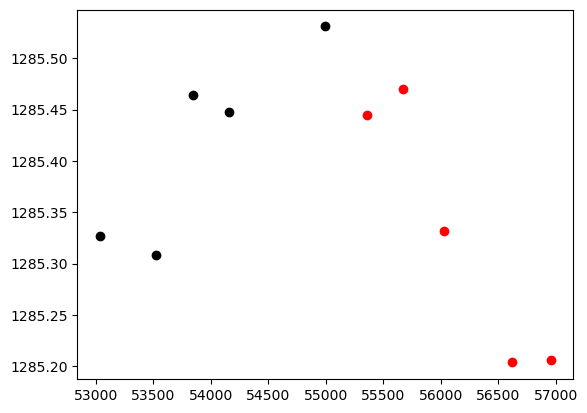

In [97]:
up=df_combo['sec since midnight']<55000
plt.plot(df_combo['sec since midnight'].loc[up], df_combo['Diad1_Cent'].loc[up],  'ok')
plt.plot(df_combo['sec since midnight'].loc[~up], df_combo['Diad1_Cent'].loc[~up],  'or')

plt.ticklabel_format(useOffset=False)


Text(0, 0.5, 'Diad 1 Peak')

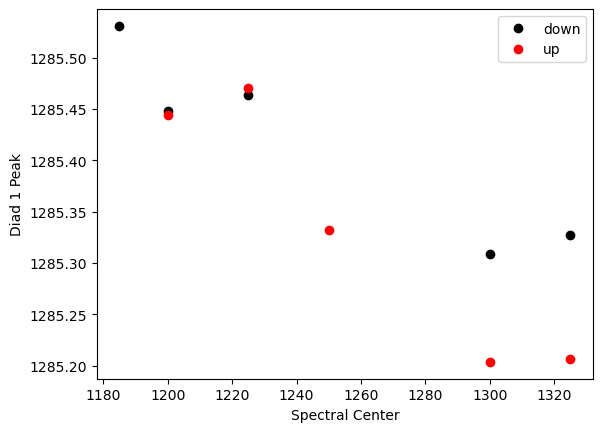

In [98]:
up=df_combo['sec since midnight']<55000
plt.plot(df_combo['Spectral Center'].loc[up], df_combo['Diad1_Cent'].loc[up],  'ok', label='down')
plt.plot(df_combo['Spectral Center'].loc[~up], df_combo['Diad1_Cent'].loc[~up],  'or', label='up')

plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Spectral Center')
plt.ylabel('Diad 1 Peak')


Text(0, 0.5, 'Diad 1 Peak')

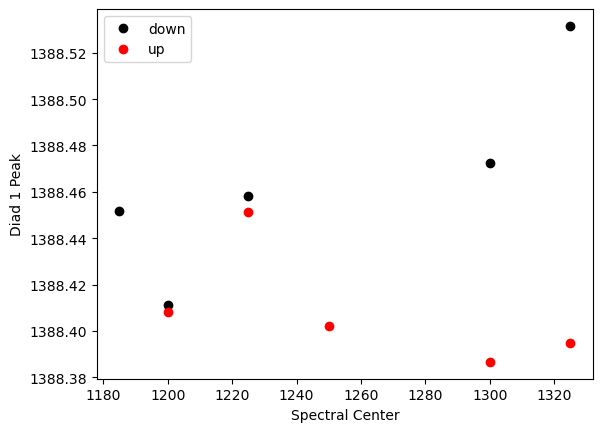

In [99]:
up=df_combo['sec since midnight']<55000
plt.plot(df_combo['Spectral Center'].loc[up], df_combo['Diad2_Cent'].loc[up],  'ok', label='down')
plt.plot(df_combo['Spectral Center'].loc[~up], df_combo['Diad2_Cent'].loc[~up],  'or', label='up')

plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Spectral Center')
plt.ylabel('Diad 1 Peak')


## Now load in the model for doing the Ne fitting

In [63]:
from pickle import load
import pickle

pickle_path='G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\High_Density_Looping_Run'
file_pkl=pickle_path + '/' + 'Ne_Line_Regression_ExampleVIBE.pck'
with open(file_pkl, 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

In [46]:
df_combo['Ne_Correction']=my_loaded_model(df_combo['sec since midnight'])
df_combo['Corrected_Splitting']=df_combo['Ne_Correction']*df_combo['Splitting']

In [47]:
df_combo['Ne_Correction']

0    0.999264
1    0.999287
2    0.999070
3    0.999143
4    0.998816
5    0.998427
6    0.998913
7    0.997538
8    0.998394
9    0.996908
Name: Ne_Correction, dtype: float64

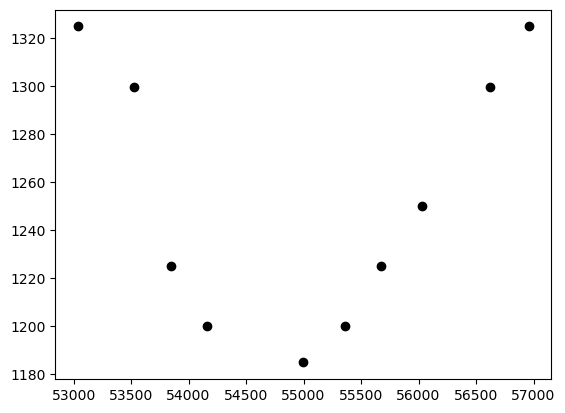

In [48]:

plt.plot(df_combo['sec since midnight'], df_combo['Spectral Center'], 'ok')

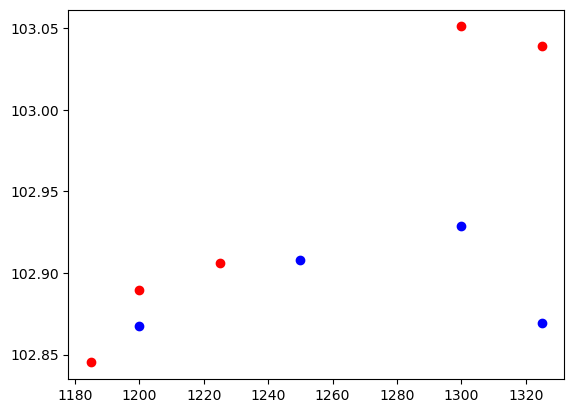

In [49]:

Filt=df_combo['Diad2_Area']<2000
plt.plot(df_combo['Spectral Center'].loc[Filt&up], df_combo['Corrected_Splitting'].loc[Filt&up],
           'or')
plt.plot(df_combo['Spectral Center'].loc[Filt&(~up)], df_combo['Corrected_Splitting'].loc[Filt&(~up)],
           'ob')

Text(0, 0.5, 'Splitting')

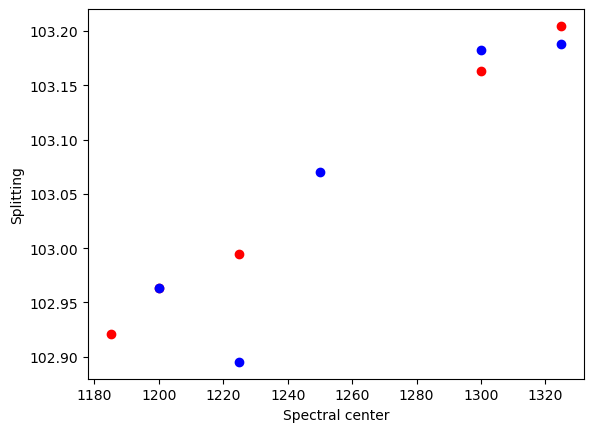

In [50]:
plt.plot(df_combo['Spectral Center'].loc[up], df_combo['Splitting'].loc[up],
           'or')
plt.plot(df_combo['Spectral Center'].loc[~up], df_combo['Splitting'].loc[~up],
           'ob')
plt.xlabel('Spectral center')
plt.ylabel('Splitting')


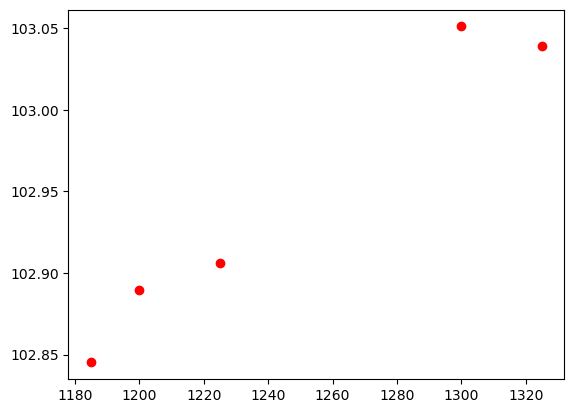

In [40]:
plt.plot(df_combo['Spectral Center'].loc[Filt&up], df_combo['Corrected_Splitting'].loc[Filt&up],
           'or')

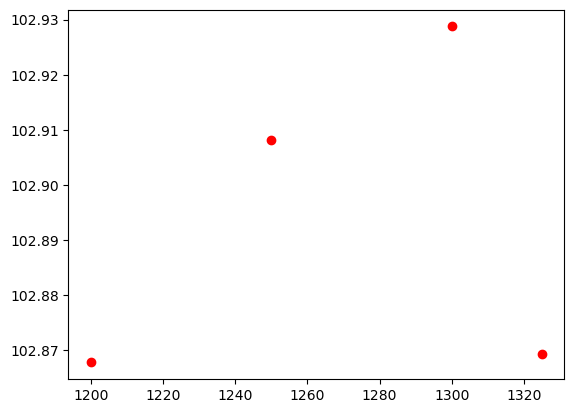

In [41]:
plt.plot(df_combo['Spectral Center'].loc[Filt&(~up)], df_combo['Corrected_Splitting'].loc[Filt&(~up)],
           'or')

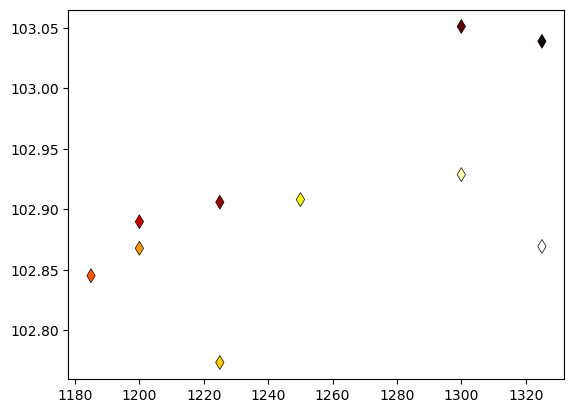

In [40]:
plt.scatter(df_combo['Spectral Center'], df_combo['Corrected_Splitting'],
            marker='d', s=50, edgecolors='k', linewidths=0.5,
             cmap='hot',
            c=df_combo['sec since midnight'])

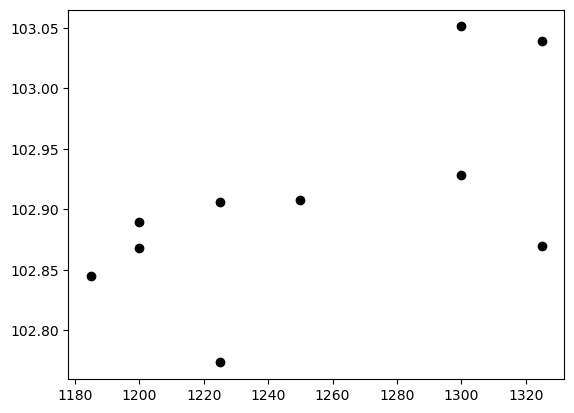

In [41]:
plt.plot(df_combo['Spectral Center'], df_combo['Corrected_Splitting'], 'ok')